# <span style="color:blue">Анализ влияния различных факторов на<br />успеваемость отметки студентов (учеников школы)<br />за государственный экзамен по математике</span>

## Основные цели и задачи проекта

Основная задача:<br />
отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике,
чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

- Провести первичный анализ и очистку данных от пустых или бессмысленных значений;
- Устранить выбросы в числовых данных;
- Найти числовые переменные, влияющие на оценку за экзамен по математике провести их анализ;
- Найти номинативные переменные, влияющие на оценку за экзамен по математике;
- Сформулировать и подтвердить либо опровергнуть набор гипотез о влиянии<br/>
  тех или иных факторов на экзаменационные оценки по математике;
- Предложить итоговый набор ограниченный переменных из очищенного набора данных;
- Сделать сводку итоговых выводов по проведённому разведовательному анализу данных.

## Загрузка кода для работы с данными

### Импорт библиотек и функций для анализа

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import iqr

### Подпрограммы для проверки данных

In [2]:
def is_datacolumn_nominal(column: pd.Series):
    """Проверяет является колонка column колонкой с номинативными данными.
    
    Parameters:
        column - некоторый объект типа pd.Series

    Returns:
        See description.
    """
    return column.dtypes == np.object


def verify_column_domain_in_list(column: pd.Series, values: list):
    """Проверяет значений в колонке column на принадлежность домену,
    определяемому набором значений values.
    
    Parameters:
        column - некоторый объект типа pd.Series
        values - набор значений, принадлежащих домену, определённому для колонки column

    Returns:
        Возвращает те значений, которые не принадлежат домену,
        определённому для колонки column набором values.
    """
    nondomain_values = column[~column.isin(values)]
    return nondomain_values


def verify_column_domain(column: pd.Series, predicate):
    """Проверяет значений в колонке column на принадлежность домену,
    определяемому предикатом-функцией predicate.
    
    Parameters:
        column - некоторый объект типа pd.Series
        predicate - предикат, определяющий значения, принадлежащие домену, определённому для колонки column

    Returns:
        Возвращает те значений, которые не принадлежат домену,
        определённому для колонки column предикатом-функцией predicate.
    """
    nondomain_values = column[~predicate(column)]
    return nondomain_values

### Подпрограммы для очистки и предварительной обработки данных

In [3]:
def drop_rows_by_domain_list(column_name: str, data: pd.DataFrame, values: list):
    """Удаляет строки из набора данных data,
    если они не входят в домен, определяемый фиксированным набором значений values.
    
    Parameters:
        column_name - имя колонки в наборе данных data для
                      поиска значений, выходящих за предметную область
        data - некоторый набор данных
        values - набор значений из предметной области колонки, которые мы принимаем за верные
    """
    data.drop(data[~data[column_name].isin(values)].index, inplace=True)


def drop_rows_by_domain(column_name: str, data: pd.DataFrame, predicate):
    """Удаляет строки из набора данных data,
    если они не входят в домен, определяемый предикатом-функцией predicate.
    
    Parameters:
        column_name - имя колонки в наборе данных data для
                      поиска значений, выходящих за предметную область
        data - некоторый набор данных
        predicate - предикат для проверки данных из колонки с именем column_name
    """
    data.drop(data[~predicate(data[column_name])].index, inplace=True)


def clear_nominal_datacolumn(column: pd.Series):
    """Replaces NaN values and empty string values in a object/string column with None values
    
    Parameters:
        data - a Series object to look for 'nan' and empty strings

    Returns:
        Cleared column data
    """
    if is_datacolumn_nominal(column):
        return column.astype(str).apply(
            lambda value: None if pd.isnull(value) \
                else None if value.strip() == '' \
                else None if value.lower() == 'nan' \
                else value
        )
    else:
        return column


def clear_dataframe(data: pd.DataFrame):
    """Replaces NaN values and empty string values in all pd.DataFrame object/string columns with None values
    
    Parameters:
        data - a DataFrame
    """
    for column_name in data.columns:
        if is_datacolumn_nominal(data[column_name]):
            data[column_name] = clear_nominal_datacolumn(data[column_name])


def convert_float_column_to_int(column_name: str, data: pd.DataFrame):
    """Функция преобразования данных типа float колонки с именем column_name
    в данные типа int.
    Сейчас не используется, поскольку в наборе могут быть значения NaN.

    Parameters:
        column_name - имя колонки типа float в наборе данных data
        data - некоторый набор данных
    
    Returns:
        See description.
    """
    data[column_name] = data[column_name].astype(int)

#### Подпрограммы для преобразования некоторых номинативных данных, которые<br />заданы числовыми кодами в читабельный строковый формат

In [4]:
def number_code_to_meaning(code: float, code_meanings: dict):
    """Функция преобразования числовых значений (например в колонке)
    в другие значения из словаря. Например числовых данных в номинативные.
    Сейчас не используется.

    Parameters:
        code - некоторое числовое значение, используемое в качестве ключа в словаре code_meanings
        code_meanings - словарь, содержащий замены для значений типа code
    
    Returns:
        See description.
    """
    if math.isnan(code) or math.isinf(code):
        return None
    else:
        code_key = int(code)
        if code_key in code_meanings:
            return code_meanings[code_key]
        else:
            return None

#### Подпрограммы для рисования графиков

In [5]:
def get_boxplot(data: pd.DataFrame, column_x, column_y):
    """Рисование диаграммы boxplot для
    колонки column_x по оси абсцисс и колонки column_y по оси ординат.

    Parameters:
        data - общий набор данных, в колонке column которого найдены выбросы
        column_x - колонка с данными, откладываемыми по оси абсцисс
        column_y - колонка с данными, откладываемыми по оси ординат
    
    Returns:
        See description.
    """
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(
        x=column_x, y=column_y.name, 
        data=data.loc[data.loc[:, column_x].isin(data.loc[:, column_x].value_counts().index[:10])],
        ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column_x)
    plt.show()

##### Преобразование числового кода уровня образования человека в строку

In [6]:
education_levels = {
    0: "no education",
    1: "1-4 class",
    2: "5-9 class",
    3: "10-11 class / special",
    4: "higher education"
}


# Решил не преобразовывать в номинативные данные, чтобы проще было учитывать корреляции
def education_level(level_code: float):
    return number_code_to_meaning(level_code, education_levels)

##### Преобразование числового кода примерного времени пути до школы в понятную строку

In [7]:
travel_times = {
    1: "< 15 min",
    2: "15-30 min",
    3: "30-60 min",
    4: "> 60 min"
}


# Решил не преобразовывать в номинативные данные, чтобы проще было учитывать корреляции
def travel_duration(travel_time_code: float):
    return number_code_to_meaning(travel_time_code, travel_times)

##### Преобразование числового кода дополнительного времени на учёбу в понятную строку

In [8]:
study_times = {
    1: "1 - < 2 hrs",
    2: "2 - 2-5 hrs",
    3: "3 - 5-10 hrs",
    4: "4 - > 10 hrs",
}


# Решил не преобразовывать в номинативные данные, чтобы проще было учитывать корреляции
def extra_studies_duration(duration_code: float):
    return number_code_to_meaning(duration_code, study_times)

### Подпрограммы для нахождения квартилей и устранения выбросов для числовых данных

In [9]:
def q1_value(column: pd.Series):
    """Вычисление первого квартиля в заданной колонке.

    Parameters:
        column - колонка для нахождения квартиля
    
    Returns:
        See description.
    """
    return column.quantile(q=0.25)


def q3_value(column: pd.Series):
    """Вычисление третьего квартиля в заданной колонке.

    Parameters:
        column - колонка для нахождения квартиля
    
    Returns:
        See description.
    """
    return column.quantile(q=0.75)


def q2_value(column: pd.Series):
    """Вычисление медианы в заданной колонке.

    Parameters:
        column - колонка для нахождения медианы
    
    Returns:
        See description.
    """
    return column.quantile(q=0.5)


def iqr_value(column: pd.Series):
    """Вычисление интерквартильного размаха.

    Parameters:
        column - колонка для нахождения интерквартильного размаха
    
    Returns:
        See description.
    """
    return q3_value(column) - q1_value(column)


def outlier_borders(column: pd.Series):
    """Вычисление границ для нахождения выбросов.

    Parameters:
        column - колонка для нахождения границ, за которыми могут быть выбросы
    
    Returns:
        See description.
    """
    q1 = q1_value(column)
    q3 = q3_value(column)
    iqr = iqr_value(column)
    print(f"q1 = {q1}, q3 = {q3}, borders = {(q1 - 1.5 * iqr, q3 + 1.5 * iqr)}")
    return (q1 - 1.5 * iqr, q3 + 1.5 * iqr)


def outliers_datacolumn(column: pd.Series):
    """Вычисление выбросов.

    Parameters:
        column - колонка для нахождения выбросов
    
    Returns:
        See description.
    """
    borders = outlier_borders(column)
    return column[(column < borders[0]) | (column > borders[1])]


def get_outliers(outliers: pd.Series, column: pd.Series, data: pd.DataFrame):
    """Получение полной таблицы записей с выбросами в заданной колонке.

    Parameters:
        outliers - объект pd.Series, содержащий индексы и значения выбросов в колонке column
        column - колонка, содержащая выбросы
        data - общий набор данных, в колонке column которого найдены выбросы
    
    Returns:
        See description.
    """
    print(f"Выбросы в колонке '{column.name}': {outliers}")
    msg_no_outliers = f"Выбросов в колонке '{column.name}' НЕТ"
    msg_have_outliers = f"Выбросы в колонке '{column.name}' ЕСТЬ: {len(outliers.index)} выброс(а/ов)"
    print(f"{msg_no_outliers if outliers.empty else msg_have_outliers}")
    if not outliers.empty:
        return data[data[column.name].isin(outliers)]
    else:
        return pd.DataFrame()


def drop_outliers(outliers: pd.Series, column: pd.Series, data: pd.DataFrame):
    """Удаление записей из полного набора занных data с выбросами в заданной колонке column.

    Parameters:
        outliers - объект pd.Series, содержащий индексы и значения выбросов в колонке column
        column - колонка, содержащая выбросы
        data - общий набор данных, в колонке column которого найдены выбросы
    
    Returns:
        See description.
    """
    data.drop(data[data[column.name].isin(outliers)].index, inplace=True)

### Подпрограммы для теста Стьюдента

In [10]:
def find_statistical_differences(data: pd.DataFrame, column: str, target_column: str):
    """Осуществляет множественную проверку гипотезы об отсутствии
    статистически значимых различий при рассмотрении различных фиксируемых значений
    номинативной переменной column по отношению к числовой переменной target_column. 

    Parameters:
        data - некоторый набор данных
        column - колонка с номинативными данными,
                 которые могут принадлежать некоторому набору уникальных строковых значений.
        target_column - колонка с числовыми показателями (рейтинг, отметка за экзамен),
                        для значений из которой ищутся заметные статистические отличия
                        при сопоставлении этого численного показател для разных значений
                        из номинативной колонки column
    
    Returns:
        See description.
    """
    # Предполагаем, что нам хватит первых десыти самых частых значений из номинативной переменной column.
    # В случае с набором данных из этого проекта это всегда выполняется (во всех таких колонках значений меньше 10-ти).
    columns = data.loc[:, column].value_counts().index[:10]

    # Образуем все возможные комбинации по два из номинативных значений колонки column
    combinations_all = list(combinations(columns, 2))

    # Делаем тест Стьюдента множество раз по числу комбинаций значений из колонки column
    for combination in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == combination[0], target_column],
                     data.loc[data.loc[:, column] == combination[1], target_column]).pvalue \
                     <= 0.05/len(combinations_all): # Учёт поправки Бонферони (при множественном тестировании гипотезы некоторое число раз - число комбинаций значений колонки)
            print(f"\u2611 Найдены статистически значимые различия для номинативных данных (различных значений) колонки \"{column}\" по отношению к значениям в колонке \"{target_column}\"")
            found_differences = True
            break
    else:
        print(f"\u2612 Статистически значимых различий для номинативных данных (различных значений) колонки \"{column}\" по отношению к значениям в колонке \"{target_column}\" НЕ НАЙДЕНО.")


### Настройка библиотеки для работы с данными

In [11]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

## 0. Загрузка сырых данных

### 0.1 Загрузка сырых данных из файла

In [12]:
students_raw = pd.read_csv('stud_math.csv')

### 0.2 Отображение первых нескольких строк сырых данных

In [13]:
display(students_raw.head(10))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


### 0.3 Сводная информация о загруженных данных

In [14]:
students_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

## 1. Первичная обработка данных

### 1.2 Преобразование числовых значений в некоторых колонках

In [15]:
# Создаём копию данных о студентах, чтобы модифицировать именно её.
students = students_raw.copy(deep=True)

# Преобразование кодов уровня образования родителей из чисел с плавающей точкой в строки
# Я решил. что это делать не стоит - проще считать корреляции.
# students["Medu"] = students["Medu"].apply(education_level)
# students["Fedu"] = students["Fedu"].apply(education_level)

# Преобразование кодов, обозначающих время пути в школу в понимаемые строки
# Я решил. что это делать не стоит - проще считать корреляции.
# students["traveltime"] = students["traveltime"].apply(travel_duration)

# Преобразование кодов, обозначающих затрачиваемое дополнительное время для занятий вне школы
# Я решил. что это делать не стоит - проще считать корреляции.
# students["studytime"] = students["studytime"].apply(extra_studies_duration)

### 1.3 Очистка сырых данных необрабатываемых значений
Производится очистка номинативных данных таблицы студентов (students) от
значений NaN и от пустых строковых значений.

In [16]:
clear_dataframe(students)

### 1.4 Колонка "studytime, granular"

Указанная колонка не описана в итоговом задании.<br />
Она содержит некоторый набор отрицательных чисел.
Проверим, что все числа из колонки "studytime, granular"<br />
соответствуют значениям из колонки "studytime" по простой формуле:

\begin{equation}
\text{"studytime, granular"} = -3.0 \cdot \text{studytime}\,,\tag{1}
\label{eq:studytime_granular}
\end{equation}

где $\text{studytime} \in \lbrace NaN, 1.0, 2.0, 3.0, 4.0 \rbrace$.<br />
Ниже приведён код этой проверки с использованием неизменённых данных из<br />
объекта `students_raw` типа `DataFrame`.

In [17]:
studytime_granular = students_raw["studytime, granular"]
studytime = students_raw["studytime"]

# Правило сравнения колонок "studytime, granular" и "studytime" из уравнения (1).
comparison_rule = lambda x, y: y == -3.0 * x

test_full_correspondence = students_raw.apply(
    lambda row: \
        True if math.isnan(row["studytime, granular"]) and math.isnan(row["studytime"]) \
        else True if math.isinf(row["studytime, granular"]) and math.isinf(row["studytime"]) \
        else True if comparison_rule(row["studytime"], row["studytime, granular"]) \
        else False,
    axis=1
)

print(f"""Верно ли для каждой строки таблицы \"students_raw\",
что все значения в колонках \"studytime, granular\" и \"studytime\"
либо одновременно не указаны (NaN, Inf),
либо связаны правилом \"studytime, granular\" = −3.0 ⋅ studytime?
Ответ - {'ДА' if test_full_correspondence.all() else '!!!НЕТ!!!'}""")

Верно ли для каждой строки таблицы "students_raw",
что все значения в колонках "studytime, granular" и "studytime"
либо одновременно не указаны (NaN, Inf),
либо связаны правилом "studytime, granular" = −3.0 ⋅ studytime?
Ответ - ДА


На основании положительного ответа на последний вопрос можно сделать вывод,<br />
что данные колонки "studytime, granular" не привносят какой-либо новой информации о<br />
студентах в таблицу "students_raw" и, как следствие в предобработанную таблицу "students".<br />
Для информации о примерном количестве часов дополнительного обучения вне школы<br />
можно и далее использовать колонку "studytime".

На основании этого вывода мы можем удалить колонку "studytime, granular" из таблицы "students".

In [18]:
students.drop("studytime, granular", inplace=True, axis=1)

### 1.4 Отображение первых нескольких строк очищенных данных

In [19]:
display(students.head(10))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,None,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,None,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,None,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,None,no,yes,yes,yes,None,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,None,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,None,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,None,None,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


### 1.5 Сводная информация об очищенных данных для проверки

In [20]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    int64  
 3   address     378 non-null    object 
 4   famsize     368 non-null    object 
 5   Pstatus     350 non-null    object 
 6   Medu        392 non-null    float64
 7   Fedu        371 non-null    float64
 8   Mjob        376 non-null    object 
 9   Fjob        359 non-null    object 
 10  reason      378 non-null    object 
 11  guardian    364 non-null    object 
 12  traveltime  367 non-null    float64
 13  studytime   388 non-null    float64
 14  failures    373 non-null    float64
 15  schoolsup   386 non-null    object 
 16  famsup      356 non-null    object 
 17  paid        355 non-null    object 
 18  activities  381 non-null    object 
 19  nursery     379 non-null    o

## 2. Распределения признаков для числовых переменных и<br/>устранение выбросов

### 2.1 Колонка age (№3) - Возраст студента

In [21]:
print(f"Число уникальных значений: {students.age.nunique()}")
print(f"Уникальные значения: {students.age.unique()}")
print("Общее описание признака:")
students.age.describe()

Число уникальных значений: 8
Уникальные значения: [18 17 15 16 19 22 20 21]
Общее описание признака:


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

#### Распределение  признака

##### Распределение данных по строкам

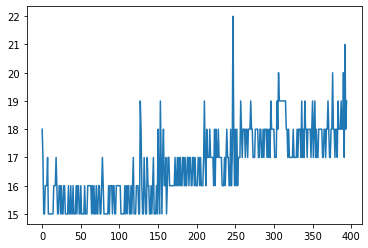

In [22]:
plt.plot(students.age)

##### Распределение признака по значениям

(array([ 82., 104.,  98.,   0.,  82.,  24.,   0.,   3.,   1.,   1.]),
 array([15. , 15.7, 16.4, 17.1, 17.8, 18.5, 19.2, 19.9, 20.6, 21.3, 22. ]),
 <a list of 10 Patch objects>)

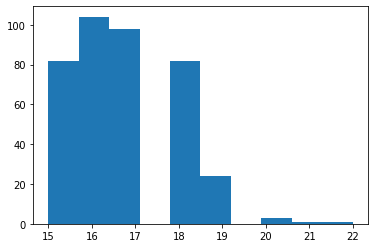

In [23]:
plt.hist(students.age)

In [24]:
outliers = outliers_datacolumn(students.age)
outlier_data = get_outliers(outliers, students.age, students)
if not outlier_data.empty:
    display(outlier_data)

q1 = 16.0, q3 = 18.0, borders = (13.0, 21.0)
Выбросы в колонке 'age': 247    22
Name: age, dtype: int64
Выбросы в колонке 'age' ЕСТЬ: 1 выброс(а/ов)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
247,GP,M,22,U,GT3,T,3.0,1.0,services,services,other,mother,1.0,1.0,3.0,no,no,no,no,no,no,yes,yes,5.0,4.0,5.0,1.0,16.0,40.0


Имеющееся распределение явно смещено вправо.

Удалим единственный выброс, соответствующий возрасту ученика в 22 года.

In [25]:
print(f"""Общее количество записей до удаления выбросов по возрасту студентов: {len(students.index)}""")
drop_outliers(outliers, students.age, students)
print(f"""Общее количество записей после удаления выбросов по возрасту студентов: {len(students.index)}""")

Общее количество записей до удаления выбросов по возрасту студентов: 395
Общее количество записей после удаления выбросов по возрасту студентов: 394


**Гипотеза 1:** Чем больше возраст у ученика, тем ниже отметки за гос. экзамен по математике у таких учеников.

### 2.2 Колонка Medu (№7) - Образование матери

In [26]:
Medu_value_counts = pd.DataFrame(students.Medu.value_counts())
display(Medu_value_counts)

,Medu
4.0,131
2.0,102
3.0,96
1.0,59
0.0,3


Больше всего по количеству та группа матерей, у которых есть высшее образование.<br />
Затем количество в каждой группе постепенно снижается со снижением уровня образования.

**Гипотеза 2:** Чем выше уровень образования матери, тем выше отметки за гос. экзамен по математике у таких учеников.

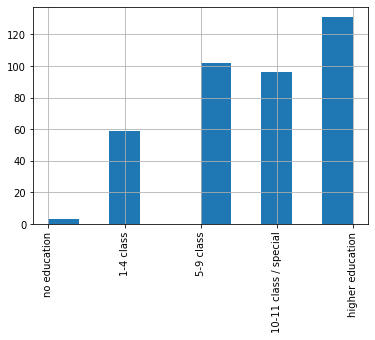

In [27]:
plot_Medu = students.Medu.hist()
plot_Medu.set_xticks(list(education_levels.keys()))
plot_Medu.set_xticklabels(list(education_levels.values()), rotation=90)
plot_Medu

### 2.3 Колонка Fedu (№8) - Образование отца

In [28]:
Fedu_value_counts = pd.DataFrame(students.Fedu.value_counts())
display(Fedu_value_counts)

,Fedu
2.0,106
3.0,96
4.0,88
1.0,77
0.0,2
40.0,1


В данных имеется одно зачение, не принадлежащее домену для этой переменной.
Удалим эту запись из набора.

In [29]:
nondomain_values = verify_column_domain_in_list(students.Fedu, [float("NaN"), 0, 1, 2, 3, 4])
print(f"""Количество записей, выходящих за границы домена: {len(nondomain_values)},
Общее количество записей: {len(students.index)}""")

print("----------")

drop_rows_by_domain_list("Fedu", students, [float("NaN"), 0, 1, 2, 3, 4])
nondomain_values = verify_column_domain_in_list(students.Fedu, [float("NaN"), 0, 1, 2, 3, 4])
print(f"""Количество записей, выходящих за границы домена: {len(nondomain_values)},
Общее количество записей: {len(students.index)}""")

Количество записей, выходящих за границы домена: 1,
Общее количество записей: 394
----------
Количество записей, выходящих за границы домена: 0,
Общее количество записей: 393


In [30]:
Fedu_value_counts = pd.DataFrame(students.Fedu.value_counts())
display(Fedu_value_counts)

,Fedu
2.0,106
3.0,96
4.0,88
1.0,77
0.0,2


Группа отцов, у которых есть высшее образование менее многоличлена, чем остальные группы<br />
С более низким уровнем образвания. Больше всего из данного набора есть учеников, у которых отцы<br />
имеют уровень образования 5-9 классов.

**Гипотеза 3:** Чем выше уровень образования отца, тем выше отметки за гос. экзамен по математике у таких учеников.

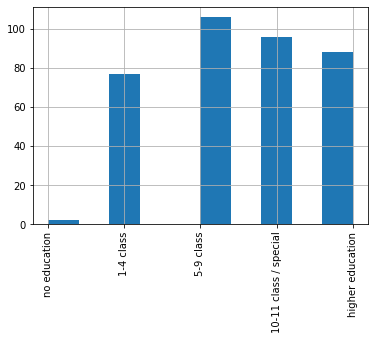

In [31]:
plot_Fedu = students.Fedu.hist()
plot_Fedu.set_xticks(list(education_levels.keys()))
plot_Fedu.set_xticklabels(list(education_levels.values()), rotation=90)
plot_Fedu

### 2.4 Колонка traveltime (№13) - Время в пути до школы

In [32]:
traveltime_value_counts = pd.DataFrame(students.traveltime.value_counts())
display(traveltime_value_counts)

,traveltime
1.0,241
2.0,96
3.0,21
4.0,7


In [33]:
nondomain_values = verify_column_domain_in_list(students.traveltime, [float("NaN"), 1, 2, 3, 4])
print(f"""Количество записей, выходящих за границы домена: {len(nondomain_values)},
Общее количество записей: {len(students.index)}""")

Количество записей, выходящих за границы домена: 0,
Общее количество записей: 393


Большая часть учеников живёт в менее чем в 15 минутах от своей школы.

**Гипотеза 4:** Чем дольше добираются ученики до школы, тем ниже отметка за гос. экзамен по математике у таких учеников.

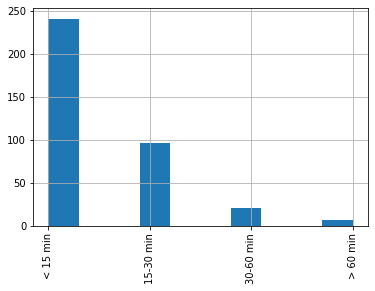

In [34]:
plot_traveltime = students.traveltime.hist()
plot_traveltime.set_xticks(list(travel_times.keys()))
plot_traveltime.set_xticklabels(list(travel_times.values()), rotation=90)
plot_traveltime

### 2.4 Колонка studytime (№14) - Время в пути до школы

In [35]:
studytime_value_counts = pd.DataFrame(students.studytime.value_counts())
display(studytime_value_counts)

,studytime
2.0,194
1.0,102
3.0,63
4.0,27


In [36]:
nondomain_values = verify_column_domain_in_list(students.studytime, [float("NaN"), 1, 2, 3, 4])
print(f"""Количество записей, выходящих за границы домена: {len(nondomain_values)},
Общее количество записей: {len(students.index)}""")

Количество записей, выходящих за границы домена: 0,
Общее количество записей: 393


Большая часть учеников отводит на учёбу вне школы от 2-х до 5-ти часов.

**Гипотеза 5:** Чем больше внешкольного времени проводях ученики дома за занятиями дома, тем выше отметки за гос. экзамен по математике у таких учеников.

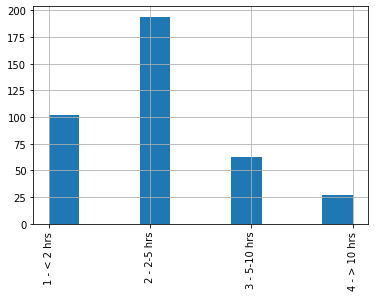

In [37]:
plot_studytime = students.studytime.hist()
plot_studytime.set_xticks(list(study_times.keys()))
plot_studytime.set_xticklabels(list(study_times.values()), rotation=90)
plot_studytime

### 2.4 Колонка failures (№15) - Количество внеучебных неудач

In [38]:
failures_value_counts = pd.DataFrame(students.failures.value_counts())
display(failures_value_counts)

,failures
0.0,292
1.0,49
2.0,16
3.0,14


Большая часть учеников либо не имеет внеучебных неудач, либо их невозможно зарегистрировать внутри системы образования. С количеством неудач доля таких учеников снижается.

**Гипотеза 6:** Чем больше внешкольных неудач (проигрыш в спортивных соревнованиях, личные проблемы и т.п.) у учеников, тем ниже отметки за гос. экзамен по математике у таких учеников.

In [39]:
failures_value_counts_normalized = (pd.DataFrame(students.failures.value_counts(normalize=True)) * 100.) \
    .reset_index().rename(columns = {"index": "failures", "failures": "students"})
display(failures_value_counts_normalized)

,failures,students
0,0.0,78.706199
1,1.0,13.207547
2,2.0,4.312668
3,3.0,3.773585


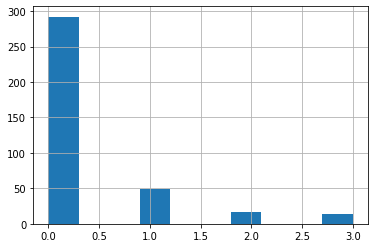

In [40]:
plot_failures = students.failures.hist()
plot_failures

Text(0, 0.5, 'Percent of students, %')

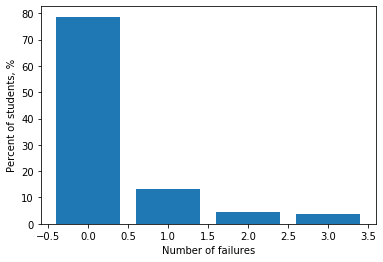

In [41]:
plt.bar(failures_value_counts_normalized.failures,
        failures_value_counts_normalized.students,
        align='center')
plt.xlabel('Number of failures')
plt.ylabel('Percent of students, %')

### 2.2 Колонка famrel (№24) - Семейные отношения

#### Удаление записей, со значениями, не входящими в домен

In [42]:
nondomain_values = verify_column_domain_in_list(students.famrel, [float("NaN"), 1, 2, 3, 4, 5])
print(f"""Количество записей, выходящих за границы домена: {len(nondomain_values)},
Общее количество записей: {len(students.index)}""")
print("Записи с недоменными значениями:")
students[students.famrel.isin(nondomain_values)]
print(f"Рассмотрение отдельных случаев {'НЕ ТРЕБУЕТСЯ' if nondomain_values.empty else '!!!ТРЕБУЕТСЯ!!!'}")

Количество записей, выходящих за границы домена: 1,
Общее количество записей: 393
Записи с недоменными значениями:
Рассмотрение отдельных случаев !!!ТРЕБУЕТСЯ!!!


Количество записей с неверной оценкой семейных отношений (-1.0) мало (одна запись),<br />
поэтому эту одну запись "можно" удалить, не повлияв сильно на <ins>общую</ins> статистику<br />
(это ответственность соцработников, занимающихся такими отдельными случаями).

In [43]:
drop_rows_by_domain_list("famrel", students, [float("NaN"), 1, 2, 3, 4, 5])
nondomain_values = verify_column_domain_in_list(students.famrel, [float("NaN"), 1, 2, 3, 4, 5])
print(f"""Количество записей, выходящих за границы домена: {len(nondomain_values)},
Общее количество записей: {len(students.index)}""")

Количество записей, выходящих за границы домена: 0,
Общее количество записей: 392


#### Распределение признака

(array([  7.,   0.,  17.,   0.,   0.,  62.,   0., 182.,   0.,  97.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

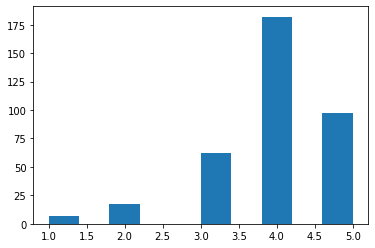

In [44]:
plt.hist(students.famrel[~np.isnan(students.famrel)])

В основном студенты оценивают свои семейные отношения на 4 балла по 5-ти бальной шкале.<br />
Распределение признака явно смещено влево.

**Гипотеза 7:** Возможно, что чем лучше семейные отношения у учеников, тем выше отметки за гос. экзамен по математике у таких учеников.

### 2.3 Колонка freetime (№25) - Свободное время после школы

#### Удаление записей, со значениями, не входящими в домен

In [45]:
nondomain_values = verify_column_domain_in_list(students.freetime, [float("NaN"), 1, 2, 3, 4, 5])
print(f"""Количество записей, выходящих за границы домена: {len(nondomain_values)},
Общее количество записей: {len(students.index)}""")
print("Записи с недоменными значениями:")
students[students.freetime.isin(nondomain_values)]
print(f"Рассмотрение отдельных случаев {'НЕ ТРЕБУЕТСЯ' if nondomain_values.empty else '!!!ТРЕБУЕТСЯ!!!'}")

Количество записей, выходящих за границы домена: 0,
Общее количество записей: 392
Записи с недоменными значениями:
Рассмотрение отдельных случаев НЕ ТРЕБУЕТСЯ


#### Распределение признака

(array([ 18.,   0.,  61.,   0.,   0., 153.,   0., 111.,   0.,  38.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

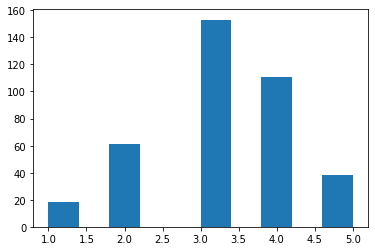

In [46]:
plt.hist(students.freetime[~np.isnan(students.freetime)])

Распределение свободного времени студентов близко к нормальному.

**Гипотеза 8:** Возможно, что чем больше неучебного свободного времени тратят ученики, тем ниже отметки за гос. экзамен по математике у таких учеников.

### 2.4 Колонка goout (№26) - Проведение времени с друзьями

#### Значения, не входящие в домен

In [47]:
nondomain_values = verify_column_domain_in_list(students.goout, [float("NaN"), 1, 2, 3, 4, 5])
print(f"""Количество записей, выходящих за границы домена: {len(nondomain_values)},
Общее количество записей: {len(students.index)}""")
print("Записи с недоменными значениями:")
students[students.goout.isin(nondomain_values)]
print(f"Рассмотрение отдельных случаев {'НЕ ТРЕБУЕТСЯ' if nondomain_values.empty else '!!!ТРЕБУЕТСЯ!!!'}")

Количество записей, выходящих за границы домена: 0,
Общее количество записей: 392
Записи с недоменными значениями:
Рассмотрение отдельных случаев НЕ ТРЕБУЕТСЯ


#### Распределение признака

(array([ 23.,   0.,  99.,   0.,   0., 127.,   0.,  84.,   0.,  51.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

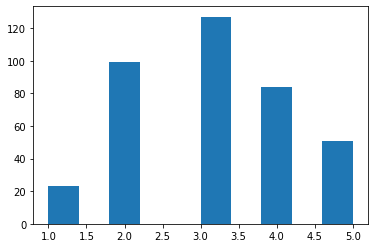

In [48]:
plt.hist(students.goout[~np.isnan(students.goout)])

**Гипотеза 9:** Возможно, что чем больше времени тратят ученики на общение с друзьями, тем ниже отметки за гос. экзамен по математике у таких учеников.

### 2.5 Колонка health (№27) - Текущее состояние здоровья

#### Значения, не входящие в домен

In [49]:
nondomain_values = verify_column_domain_in_list(students.health, [float("NaN"), 1, 2, 3, 4, 5])
print(f"""Количество записей, выходящих за границы домена: {len(nondomain_values)},
Общее количество записей: {len(students.index)}""")
print("Записи с недоменными значениями:")
students[students.health.isin(nondomain_values)]
print(f"Рассмотрение отдельных случаев {'НЕ ТРЕБУЕТСЯ' if nondomain_values.empty else '!!!ТРЕБУЕТСЯ!!!'}")

Количество записей, выходящих за границы домена: 0,
Общее количество записей: 392
Записи с недоменными значениями:
Рассмотрение отдельных случаев НЕ ТРЕБУЕТСЯ


#### Распределение признака

(array([ 46.,   0.,  43.,   0.,   0.,  89.,   0.,  62.,   0., 137.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

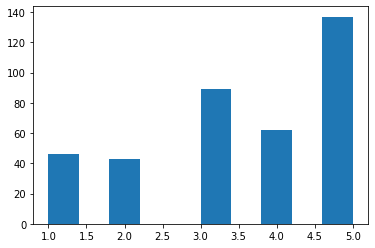

In [50]:
plt.hist(students.health[~np.isnan(students.health)])

**Гипотеза 10:** Возможно, что чем хуже здоровье у учеников, тем ниже отметки за гос. экзамен по математике у таких учеников.

### 2.7 Колонка absences (№28) - Количество пропущенных занятий

#### Распределение признака

(array([374.,   4.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([  0. ,  38.5,  77. , 115.5, 154. , 192.5, 231. , 269.5, 308. ,
        346.5, 385. ]),
 <a list of 10 Patch objects>)

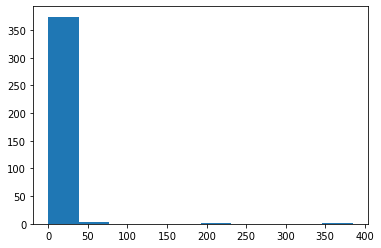

In [51]:
plt.hist(students.absences[~np.isnan(students.absences)])

Визуально имеются выбросы на этой гистограмме.
Определим те данные, которые можно удалить из набора.

In [52]:
outliers = outliers_datacolumn(students.absences)
outlier_data = get_outliers(outliers, students.absences, students)
if not outlier_data.empty:
    display(outlier_data)

q1 = 0.0, q3 = 8.0, borders = (-12.0, 20.0)
Выбросы в колонке 'absences': 40      25.0
74      54.0
103     26.0
183     56.0
198     24.0
205     28.0
216     22.0
222    385.0
260     21.0
276     75.0
277     22.0
280     30.0
307     38.0
313     22.0
315     40.0
320     23.0
390    212.0
Name: absences, dtype: float64
Выбросы в колонке 'absences' ЕСТЬ: 17 выброс(а/ов)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,None,no,yes,no,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,None,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,None,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,yes,None,no,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,None,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,None,no,no,yes,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
260,GP,F,18,U,GT3,None,4.0,3.0,None,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,None,no,no,no,no,yes,yes,NaN,1.0,1.0,5.0,75.0,45.0


#### Распределение признака в выбросах

(array([6., 3., 1., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 21.  ,  24.64,  28.28,  31.92,  35.56,  39.2 ,  42.84,  46.48,
         50.12,  53.76,  57.4 ,  61.04,  64.68,  68.32,  71.96,  75.6 ,
         79.24,  82.88,  86.52,  90.16,  93.8 ,  97.44, 101.08, 104.72,
        108.36, 112.  , 115.64, 119.28, 122.92, 126.56, 130.2 , 133.84,
        137.48, 141.12, 144.76, 148.4 , 152.04, 155.68, 159.32, 162.96,
        166.6 , 170.24, 173.88, 177.52, 181.16, 184.8 , 188.44, 192.08,
        195.72, 199.36, 203.  , 206.64, 210.28, 213.92, 217.56, 221.2 ,
        224.84, 228.48, 232.12, 235.76, 239.4 

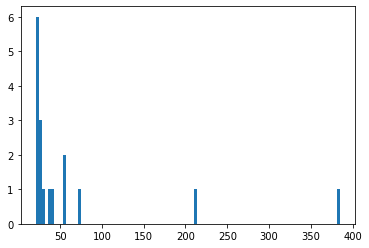

In [53]:
plt.hist(outlier_data.absences[~np.isnan(outlier_data.absences)], bins=100)

Среди выбросов есть один студент, который, по-видимому, вообще не посещал занятия (385 пропусков),<br />
но имеет достаточно хороший балл по математике (85). Посмотрим, есть ли корреляция

In [54]:
outlier_data[["absences", "score"]].corr()

,absences,score
absences,1.000000,0.299703
score,0.299703,1.000000


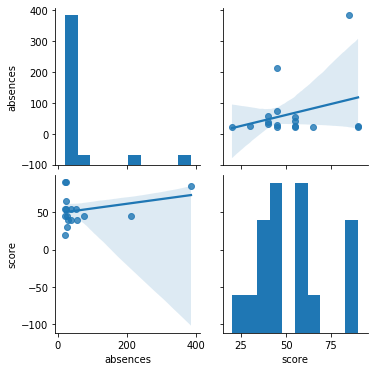

In [55]:
sns.pairplot(outlier_data[["absences", "score"]], kind='reg')

Коэффициент корреляции меду числом пропусков и оценкой за математику положителен и равен 0.29.
Те, кто пропускают занятия имеют посредственные оценки,<br />
а некоторые студенты, постоянно пропускающие занятия, имеют высокий балл.<br />
Возможно это означает, что школьные занятия по математике нуждаются в повышении качества.<br />

Так или иначе можно удалить эти 17 выбросов,<br />
которые относятся к студентам, которые не посещают занятия регулярно.<br />
Основная их масса закономерно имеют низкие отметки по математике,
а некоторые имеют высокие, поскольку видимо имеют повышенные способности.

Почти все студенты, игнорирующие посещение занятий учатся в школе с аббревиатурой "GP".

In [56]:
outlier_data[["absences", "studytime", "score"]]

,absences,studytime,score
40,25.0,2.0,55.0
74,54.0,2.0,55.0
103,26.0,2.0,30.0
183,56.0,2.0,40.0
198,24.0,1.0,90.0
205,28.0,3.0,45.0
216,22.0,2.0,20.0
222,385.0,2.0,85.0
260,21.0,2.0,90.0
276,75.0,2.0,45.0


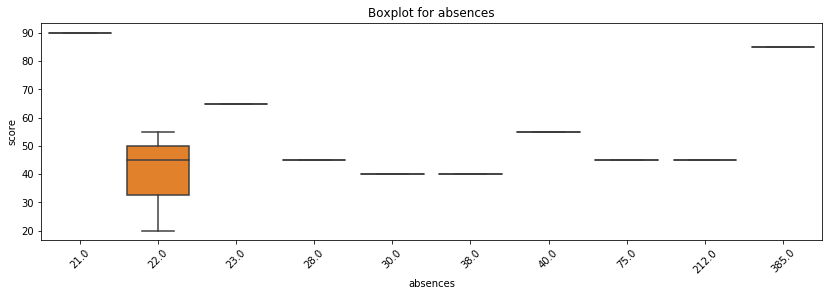

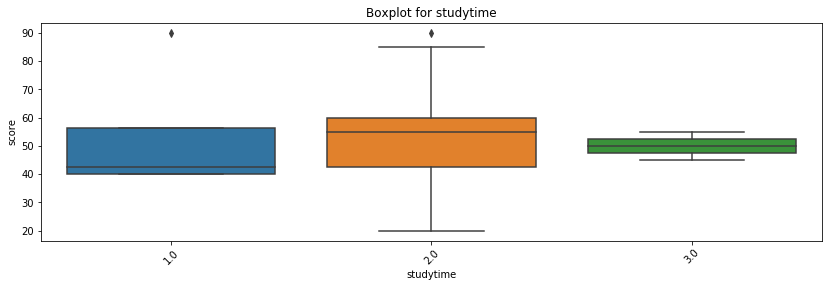

In [57]:
for column_x in ["absences", "studytime"]:
    get_boxplot(outlier_data, column_x, outlier_data.score)

Как видно из boxplot диаграмм выше даже свободное время не влияет<br />
в ту или иную сторону на оценки этих студентов.<br />
Поэтому эти  выбросы удаляются из набора.

In [58]:
print(f"""Общее количество записей до удаления выбросов по посещаемости: {len(students.index)}""")
drop_outliers(outliers, students.absences, students)
print(f"""Общее количество записей после удаления выбросов по посещаемости: {len(students.index)}""")

Общее количество записей до удаления выбросов по посещаемости: 392
Общее количество записей после удаления выбросов по посещаемости: 375


#### Распределение пропусков занятий после устранения выбросов

(array([114.,  68.,  57.,  37.,  24.,  19.,  14.,  13.,   7.,  10.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

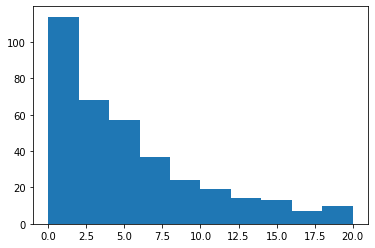

In [59]:
plt.hist(students.absences[~np.isnan(students.absences)], bins=10)

In [60]:
students.absences.describe()

count    363.000000
mean       4.548209
std        4.924823
min        0.000000
25%        0.000000
50%        3.000000
75%        7.000000
max       20.000000
Name: absences, dtype: float64

Видно, что распределение количества пропусков занятий сильно смещено вправо.<br />
Основная масса учеников в основном посещяет занятия.<br />
Медианным количеством пропусков является число **4**.

**Гипотеза 11:** Возможно, что чем больше ученики пропускают занятия, тем ниже отметки за гос. экзамен по математике у таких учеников.

### 2.8 Колонка score (№29) - Баллы по госэкзамену по математике

#### Распределение признака

(array([37.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,
         0.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,
         0., 26.,  0.,  0.,  0.,  0., 23.,  0.,  0.,  0.,  0., 54.,  0.,
         0.,  0.,  0., 42.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,
        30.,  0.,  0.,  0.,  0., 27.,  0.,  0.,  0.,  0., 33.,  0.,  0.,
         0.,  0., 16.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0., 10.,
         0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  1.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  6

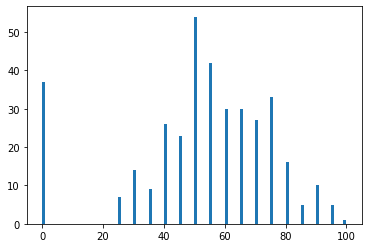

In [61]:
plt.hist(students.score[~np.isnan(students.score)], bins=100)

Распределение близко к нормальному.<br />
Стоит устранить выбросы, чтобы посмотреть на статистику оценок в среднем.

In [62]:
students.score.describe()

count    369.000000
mean      52.276423
std       23.145206
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

#### Выбросы в колонке по оценкам за экзамен

In [63]:
outliers = outliers_datacolumn(students.score)
outlier_data = get_outliers(outliers, students.score, students)
if not outlier_data.empty:
    display(outlier_data)

q1 = 40.0, q3 = 70.0, borders = (-5.0, 115.0)
Выбросы в колонке 'score': Series([], Name: score, dtype: float64)
Выбросов в колонке 'score' НЕТ


Видно, что стандартная формула вычисления выбросов не сработала для тех отметок,<br />
которые ниже 20 баллов. Поэтому устраним эти выбросы вручную.<br />
Сначала распечатаем данные для этих студентов.

In [64]:
print(f"Общее число студентов с отметками ниже 20 баллов: {len(students[students.score < 20].index)}")
display(students[students.score < 20])

Общее число студентов с отметками ниже 20 баллов: 37


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
128,GP,M,18,R,None,T,2.0,2.0,None,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
130,GP,F,15,R,GT3,T,3.0,4.0,services,teacher,course,father,2.0,3.0,2.0,no,yes,no,no,yes,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,0.0
131,GP,F,15,U,GT3,None,1.0,1.0,at_home,other,course,mother,3.0,1.0,0.0,no,yes,no,yes,no,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
134,GP,M,15,R,GT3,T,3.0,4.0,at_home,teacher,course,mother,NaN,2.0,0.0,no,yes,no,no,yes,yes,no,yes,5.0,3.0,3.0,5.0,0.0,0.0
135,GP,F,15,U,GT3,T,4.0,4.0,services,None,course,mother,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,yes,4.0,3.0,3.0,5.0,0.0,0.0
136,GP,M,17,R,GT3,T,3.0,4.0,at_home,other,course,mother,3.0,2.0,0.0,no,no,None,no,yes,yes,no,no,NaN,4.0,5.0,5.0,0.0,0.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,None,other,NaN,1.0,2.0,no,yes,no,yes,no,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,None,father,2.0,4.0,0.0,yes,yes,no,None,yes,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,home,None,1.0,1.0,3.0,no,yes,no,no,yes,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0
146,GP,F,15,U,GT3,T,3.0,2.0,health,services,home,father,1.0,2.0,3.0,no,None,no,no,yes,yes,yes,no,3.0,3.0,2.0,3.0,0.0,0.0


У всех найденных студентов отметка по экзамену равна строго нулю.<br />

In [65]:
outlier_data = students[students.score < 20]
outlier_data.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.277001,-0.308023,-0.173553,-0.043985,-0.062840,-0.013915,0.189722,0.090751,-0.224359,NaN,NaN
Medu,-0.277001,1.000000,0.763420,-0.139369,0.138471,-0.314499,-0.053375,0.178854,0.024078,-0.104942,NaN,NaN
Fedu,-0.308023,0.763420,1.000000,0.013349,0.243154,-0.257808,-0.038095,0.108777,0.126071,0.040732,NaN,NaN
traveltime,-0.173553,-0.139369,0.013349,1.000000,-0.141737,-0.247421,-0.061199,-0.067848,0.046303,-0.144564,NaN,NaN
studytime,-0.043985,0.138471,0.243154,-0.141737,1.000000,-0.345101,-0.099838,-0.102243,-0.223221,-0.000755,NaN,NaN
failures,-0.062840,-0.314499,-0.257808,-0.247421,-0.345101,1.000000,-0.136602,0.004118,0.031227,0.199496,NaN,NaN
famrel,-0.013915,-0.053375,-0.038095,-0.061199,-0.099838,-0.136602,1.000000,0.279762,0.271268,-0.068486,NaN,NaN
freetime,0.189722,0.178854,0.108777,-0.067848,-0.102243,0.004118,0.279762,1.000000,0.319699,-0.017763,NaN,NaN
goout,0.090751,0.024078,0.126071,0.046303,-0.223221,0.031227,0.271268,0.319699,1.000000,-0.093742,NaN,NaN
health,-0.224359,-0.104942,0.040732,-0.144564,-0.000755,0.199496,-0.068486,-0.017763,-0.093742,1.000000,NaN,NaN


In [66]:
students.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.190259,-0.167517,0.103550,0.005599,0.182660,0.049710,0.039631,0.130806,-0.041463,0.132373,-0.161105
Medu,-0.190259,1.000000,0.631839,-0.183392,0.098871,-0.263104,-0.019020,0.039265,0.050369,-0.037910,0.068437,0.221031
Fedu,-0.167517,0.631839,1.000000,-0.161366,0.010850,-0.281077,-0.025859,-0.009461,0.049058,0.019506,-0.009905,0.125475
traveltime,0.103550,-0.183392,-0.161366,1.000000,-0.102651,0.089575,-0.032008,-0.004561,0.038289,-0.024796,-0.040236,-0.073252
studytime,0.005599,0.098871,0.010850,-0.102651,1.000000,-0.168583,0.026641,-0.132390,-0.034421,-0.091198,-0.064586,0.116838
failures,0.182660,-0.263104,-0.281077,0.089575,-0.168583,1.000000,-0.001780,0.088871,0.096866,0.109062,0.047286,-0.348939
famrel,0.049710,-0.019020,-0.025859,-0.032008,0.026641,-0.001780,1.000000,0.164518,0.063529,0.096319,-0.082213,0.064207
freetime,0.039631,0.039265,-0.009461,-0.004561,-0.132390,0.088871,0.164518,1.000000,0.274497,0.061821,0.096817,0.041901
goout,0.130806,0.050369,0.049058,0.038289,-0.034421,0.096866,0.063529,0.274497,1.000000,0.007164,0.107455,-0.110853
health,-0.041463,-0.037910,0.019506,-0.024796,-0.091198,0.109062,0.096319,0.061821,0.007164,1.000000,-0.008002,-0.074205


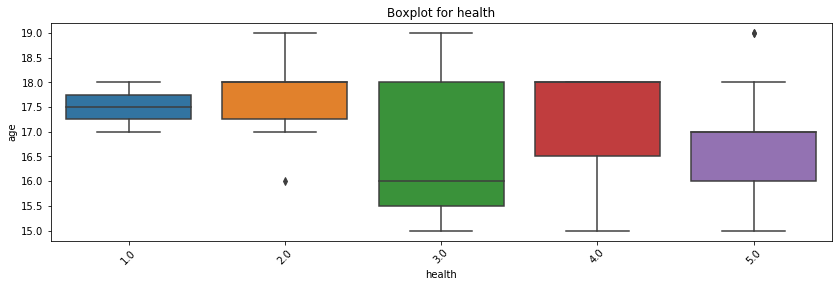

In [67]:
for column_x in ["health"]:
    get_boxplot(outlier_data, column_x, outlier_data.age)

Из boxplot по здоровью, где отображается здоровье и возраст видно наличие достаточно
большого разброса по возрастам у учеников, которые не сдавали экзамен вообще,
с неочень хорошим здоровьем (3 балла).

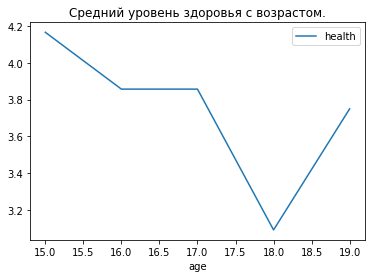

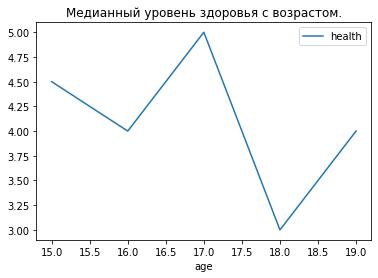

In [68]:
outliers_by_age = outlier_data[["age", "health"]].sort_values(by="age").groupby("age")
outliers_by_age.mean().reset_index().plot(x="age", y="health", title="Средний уровень здоровья с возрастом.")
outliers_by_age.median().reset_index().plot(x="age", y="health", title="Медианный уровень здоровья с возрастом.")

У студентов, не имеющих оценки за экзамен,<br />
корреляция между свободным временем и временем, затраченным на общение с друзьями (groot),<br />
выше, чем по всему набору: 0.319699 против 0.279352.<br />
Кроме этого, у студентов, не получивших никакой отметки,<br />
имеется две отрицательных корреляции:
- отношения в семье (famrel) и количество внеучебных неудач (failures) = -0.136602 против -0.001780 у всего набора;
- текущий уровень здоровья (health) и возраст (age) = -0.224359 против -0.041463 у всего набора.

Также есть три небольшие положительные корреляции:
- количество внеучебных неудач (failures) слабо коррелирует с уровнем здоровья (health): 0.199496 против 0.109062 у всего набора;
- уровень отношений в семье (famrel) и количество свободного времени (freetime): 0.279762 против 0.164518 у всего набора;
- уровень отношений в семье (famrel) и временем, затраченным на общение с друзьями (groot): 0.271268 против 0.063529 у всего набора.

Также у всех этих студентов идеальная посещаемость занятий в школе (0 пропусков),<br/>
почти отсутствует школьная образовательная поддержка (schoolsup) и<br />
часто присутствует семейная образовательная поддержка (famsup).
Подавляющая часть этих студентов учится в школе с аббревиатурой "GP".

Можно сделать следующие предположения о студентах, не сдававших экзамен:<br/>
- с возрастом указанные студенты, которые не учавствовали в экзамене, испытывают всё б'ольшие проблемы со здоровьем и поэтому проводят больше своего свободного времени с семьёй и друзьями;
- почти все они учатся в школе с аббревиатурой "GP".

**Вывод:** Таким образом, возможно, некоторая значительная часть учеников (37) могут испытывать ухудшение здоровья,<br />
поэтому они проводят больше своего времени с семьёй и друзьями<br />
и большая часть из них (33) учится в школе "GP".<br />
<ins>Возможно, что школе "GP" следует плотнее заняться поддержкой таких студентов.</ins>

#### Удаление из статистики студентов без оценки за экзамен по математике

In [69]:
outliers = outlier_data.score
print(f"""Общее количество записей до удаления выбросов по оценке за экзамен: {len(students.index)}""")
drop_outliers(outliers, students.score, students)
print(f"""Общее количество записей после удаления выбросов по оценке за экзамен: {len(students.index)}""")

Общее количество записей до удаления выбросов по оценке за экзамен: 375
Общее количество записей после удаления выбросов по оценке за экзамен: 338


(array([ 7.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  0.,  0.,
         9.,  0.,  0.,  0.,  0.,  0.,  0., 26.,  0.,  0.,  0.,  0.,  0.,
        23.,  0.,  0.,  0.,  0.,  0.,  0., 54.,  0.,  0.,  0.,  0.,  0.,
         0., 42.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,
         0., 30.,  0.,  0.,  0.,  0.,  0.,  0., 27.,  0.,  0.,  0.,  0.,
         0., 33.,  0.,  0.,  0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,
         0.,  0.,  5.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,
         0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 25.  ,  25.75,  26.5 ,  27.25,  28.  ,  28.75,  29.5 ,  30.25,
         31.  ,  31.75,  32.5 ,  33.25,  34.  ,  34.75,  35.5 ,  36.25,
         37.  ,  37.75,  38.5 ,  39.25,  40.  ,  40.75,  41.5 ,  42.25,
         43.  ,  43.75,  44.5 ,  45.25,  46.  ,  46.75,  47.5 ,  48.25,
         49.  ,  49.75,  50.5 ,  51.25,  52.  ,  52.75,  53.5 ,  54.25,
         55.  ,  55.75,  56.5 ,  57.25,  58.  ,  58.75,  59.5 ,  60.25,
  

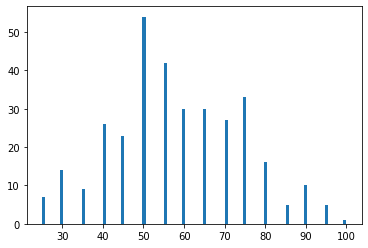

In [70]:
plt.hist(students.score[~np.isnan(students.score)], bins=100)

In [71]:
students.score.describe()

count    332.000000
mean      58.102410
std       16.001748
min       25.000000
25%       50.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

In [72]:
outliers = outliers_datacolumn(students.score)
outlier_data = get_outliers(outliers, students.score, students)
if not outlier_data.empty:
    display(outlier_data)

q1 = 50.0, q3 = 70.0, borders = (20.0, 100.0)
Выбросы в колонке 'score': Series([], Name: score, dtype: float64)
Выбросов в колонке 'score' НЕТ


В полученном итоговом наборе по оценкам за экзамен нет выбросов

## 3. Обработка данных в колонках с номинативными переменными.<br />Оценка количества уникальных значений.

### 3.1 Колонка score (№1) - Аббревиатура школы, в которой учится ученик

In [73]:
school_value_counts = pd.DataFrame(students.school.value_counts())
display(school_value_counts)

,school
GP,297
MS,41


Подавляющаа часть учеников учится в школе "GP".

Из такого небольшого набора данных невозможно вообще говоря сказать кака из двух школ "MS" или "GP" стабильно обеспечивают ученикам лучшие отметки на экзамене по математике.

In [74]:
school_MS_count = school_value_counts.school[school_value_counts.school.index == 'MS'].iloc[0]
school_GP_count = school_value_counts.school[school_value_counts.school.index == 'GP'].iloc[0]

print(f"N(MS)/N(GP) * 100% = {round((school_MS_count / school_GP_count) * 100, 1)}%")

N(MS)/N(GP) * 100% = 13.8%


Только 13.7% студентов учится в школе "MS".

### 3.2 Колонка sex (№2) - Пол ученика

In [75]:
sex_value_counts = pd.DataFrame(students.sex.value_counts())
display(sex_value_counts)

,sex
F,171
M,167


Количество учеников примерно одинаково по полам в данном наборе.

Возможно, что чем у учеников разного пола разбросы в оценках по математике могут немного отличаться.

### 3.3 Колонка address (№4) - Тип адреса ученика

In [76]:
address_value_counts = pd.DataFrame(students.address.value_counts())
display(address_value_counts)

,address
U,251
R,71


Большая часть учеников живёт в городе.

In [77]:
address_R_count = address_value_counts.address[address_value_counts.address.index == 'R'].iloc[0]
address_U_count = address_value_counts.address[address_value_counts.address.index == 'U'].iloc[0]

print(f"N(U)/N(R) * 100% = {round((address_R_count / address_U_count) * 100, 1)}%")

N(U)/N(R) * 100% = 28.3%


Примерно треть учеников живёт в сельской местности.

**Гипотеза 12**: У учеников, живущих за городом оценки отличаются от городских жителей.

### 3.4 Колонка famsize (№5) - Размер семьи

In [78]:
famsize_value_counts = pd.DataFrame(students.famsize.value_counts())
display(famsize_value_counts)

,famsize
GT3,219
LE3,97


У большей части учеников больше 3-х членов семьи.

In [79]:
famsize_LE3_count = famsize_value_counts.famsize[famsize_value_counts.famsize.index == 'LE3'].iloc[0]
famsize_GT3_count = famsize_value_counts.famsize[famsize_value_counts.famsize.index == 'GT3'].iloc[0]

print(f"N(LE3)/N(GT3) * 100% = {round((famsize_LE3_count / famsize_GT3_count) * 100, 1)}%")

N(LE3)/N(GT3) * 100% = 44.3%


У 44.9% $\approx$ 45% учеников в семье 3 человевка и меньше.

### 3.5 Колонка Pstatus (№6) - Статус совместного жилья родителей

In [80]:
Pstatus_value_counts = pd.DataFrame(students.Pstatus.value_counts())
display(Pstatus_value_counts)

,Pstatus
T,274
A,30


Большая часть родителей уччеников живут вместе.

In [81]:
Pstatus_A_count = Pstatus_value_counts.Pstatus[Pstatus_value_counts.Pstatus.index == 'A'].iloc[0]
Pstatus_T_count = Pstatus_value_counts.Pstatus[Pstatus_value_counts.Pstatus.index == 'T'].iloc[0]

print(f"N(A)/N(T) * 100% = {round((Pstatus_A_count / Pstatus_T_count) * 100, 1)}%")

N(A)/N(T) * 100% = 10.9%


Примерно у 11% учеников родители не живут вместе.

**Гипотеза 13**: У учеников, чьи родители не живут вместе, оценки могут быть ниже.

### 3.6 Колонка Mjob (№9) - Работа матери

In [82]:
Mjob_value_counts = pd.DataFrame(students.Mjob.value_counts())
display(Mjob_value_counts)

,Mjob
other,115
services,80
teacher,50
at_home,48
health,30


Большая часть матерей имеют работу, которая никак не связана с помогающими профессиями или гос. службой.

**Гипотеза 14**: Работа, профессия, матери может влиять на оценки ученика.

In [83]:
Mjob_value_counts_normalized = pd.DataFrame(students.Mjob.value_counts(normalize=True)) * 100.
display(Mjob_value_counts_normalized)

,Mjob
other,35.603715
services,24.767802
teacher,15.479876
at_home,14.860681
health,9.287926


In [84]:
print(f"Доля матерей среди помогающих профессий и госслужащих: {round(float(Mjob_value_counts_normalized.loc[['health', 'teacher', 'services']].sum()), 1)}%")
print(f"Доля матерей среди домохозяек: {round(float(Mjob_value_counts_normalized.loc[['at_home']].sum()), 1)}%")
print(f"Доля матерей среди остальных профессий: {round(float(Mjob_value_counts_normalized.loc[['other']].sum()), 1)}%")

Доля матерей среди помогающих профессий и госслужащих: 49.5%
Доля матерей среди домохозяек: 14.9%
Доля матерей среди остальных профессий: 35.6%


### 3.7 Колонка Fjob (№10) - Работа отца

In [85]:
Fjob_value_counts = pd.DataFrame(students.Fjob.value_counts())
display(Fjob_value_counts)

,Fjob
other,171
services,83
teacher,24
health,15
at_home,14


Больше половины отцов имеют работу, которая никак не связана с помогающими профессиями или гос. службой.

**Гипотеза 15**: Работа, профессия, отца может влиять на оценки ученика.

In [86]:
Fjob_value_counts_normalized = pd.DataFrame(students.Fjob.value_counts(normalize=True)) * 100.
display(Fjob_value_counts_normalized)

,Fjob
other,55.700326
services,27.035831
teacher,7.817590
health,4.885993
at_home,4.560261


In [87]:
print(f"Доля отцов среди помогающих профессий и госслужащих: {round(float(Fjob_value_counts_normalized.loc[['health', 'teacher', 'services']].sum()), 1)}%")
print(f"Доля отцов среди домохозяек: {round(float(Fjob_value_counts_normalized.loc[['at_home']].sum()), 1)}%")
print(f"Доля отцов среди остальных профессий: {round(float(Fjob_value_counts_normalized.loc[['other']].sum()), 1)}%")

Доля отцов среди помогающих профессий и госслужащих: 39.7%
Доля отцов среди домохозяек: 4.6%
Доля отцов среди остальных профессий: 55.7%


### 3.8 Колонка reason (№11) - Причина выбора школы

In [88]:
reason_value_counts = pd.DataFrame(students.reason.value_counts())
display(reason_value_counts)

,reason
course,119
reputation,91
home,82
other,31


Больше всего тех, кто выбрал школу из-за содержания образовательной программы.

In [89]:
reason_value_counts_normalized = pd.DataFrame(students.reason.value_counts(normalize=True)) * 100
display(reason_value_counts_normalized)

,reason
course,36.842105
reputation,28.173375
home,25.386997
other,9.597523


In [90]:
print(f"Доля тех, кто выбрал школу по неким необычным причинам: {round(float(reason_value_counts_normalized.loc[['other']].sum()), 1)}%")

Доля тех, кто выбрал школу по неким необычным причинам: 9.6%


Невозможно сделать какого-то заключения о том какая причина из остальных основных трёх является доминирующей.

### 3.9 Колонка guardian (№12) - Опекун

In [91]:
guardian_value_counts = pd.DataFrame(students.guardian.value_counts())
display(guardian_value_counts)

,guardian
mother,213
father,76
other,21


Больше всего тех учеников, у кого основным опекуном является мать.

In [92]:
guardian_value_counts_normalized = pd.DataFrame(students.guardian.value_counts(normalize=True)) * 100
display(guardian_value_counts_normalized)

,guardian
mother,68.709677
father,24.516129
other,6.774194


In [93]:
print(f"Доля матерей среди основных опекунов: {round(float(guardian_value_counts_normalized.loc[['mother']].sum()), 1)}%")
print(f"Доля отцов среди основных опекунов: {round(float(guardian_value_counts_normalized.loc[['father']].sum()), 1)}%")
print(f"Доля остальных опекунов: {round(float(guardian_value_counts_normalized.loc[['other']].sum()), 1)}%")

Доля матерей среди основных опекунов: 68.7%
Доля отцов среди основных опекунов: 24.5%
Доля остальных опекунов: 6.8%


**Гипотеза 16:** Ученики, у которых нет в опекунах ни матери, ни отца, могут иметь более низкие отметки за экзамен.

**Гипотеза 17:** Доля других опекунов (ни отец, ни мать) мала в этой выборке и, скорее всего, не повлияет на итоговые выводы.

### 3.10 Колонка schoolsup (№16) - Дополнительная образовательная поддержка

In [94]:
schoolsup_value_counts = pd.DataFrame(students.schoolsup.value_counts())
display(schoolsup_value_counts)

,schoolsup
no,282
yes,47


Большая часть учеников, не имеет образовательной поддержки.

In [95]:
schoolsup_value_counts_normalized = pd.DataFrame(students.schoolsup.value_counts(normalize=True)) * 100
display(schoolsup_value_counts_normalized)

,schoolsup
no,85.714286
yes,14.285714


In [96]:
print(f"Учеников с образовательной поддержкой: {round(float(schoolsup_value_counts_normalized.loc[['yes']].sum()), 1)}%")
print(f"Учеников без образовательной поддержки: {round(float(schoolsup_value_counts_normalized.loc[['no']].sum()), 1)}%")

Учеников с образовательной поддержкой: 14.3%
Учеников без образовательной поддержки: 85.7%


**Гипотеза 18:** Возможно, что та часть учеников, которая имеет образовательную поддержку будет иметь и более высокие баллы по математике.

### 3.11 Колонка famsup (№17) - Семейная образовательная поддержка

In [97]:
famsup_value_counts = pd.DataFrame(students.famsup.value_counts())
display(famsup_value_counts)

,famsup
yes,188
no,117


Большая часть учеников, имеет семейную образовательную поддержку.

In [98]:
famsup_value_counts_normalized = pd.DataFrame(students.famsup.value_counts(normalize=True)) * 100
display(famsup_value_counts_normalized)

,famsup
yes,61.639344
no,38.360656


In [99]:
print(f"Учеников с семейной образовательной поддержкой: {round(float(famsup_value_counts_normalized.loc[['yes']].sum()), 1)}%")
print(f"Учеников без семейной образовательной поддержки: {round(float(famsup_value_counts_normalized.loc[['no']].sum()), 1)}%")

Учеников с семейной образовательной поддержкой: 61.6%
Учеников без семейной образовательной поддержки: 38.4%


**Гипотеза 19:** Возможно, что та часть учеников, которая не имеет семейной образовательной поддержки будет иметь и более низкие баллы по математике.

### 3.12 Колонка paid (№18) -  Дополнительные платные занятия по математике

In [100]:
paid_value_counts = pd.DataFrame(students.paid.value_counts())
display(paid_value_counts)

,paid
no,165
yes,137


Значительная часть учеников, брала дополнительные платные занятия по математике.

In [101]:
paid_value_counts_normalized = pd.DataFrame(students.paid.value_counts(normalize=True)) * 100
display(paid_value_counts_normalized)

,paid
no,54.635762
yes,45.364238


In [102]:
print(f"Учеников бравших дополнительные платные занятия по математике: {round(float(paid_value_counts_normalized.loc[['yes']].sum()), 1)}%")
print(f"Учеников не бравших дополнительные платные занятия по математике: {round(float(paid_value_counts_normalized.loc[['no']].sum()), 1)}%")

Учеников бравших дополнительные платные занятия по математике: 45.4%
Учеников не бравших дополнительные платные занятия по математике: 54.6%


**Гипотеза 20:** Возможно, что та часть учеников, которая брала дополнительные платные занятия по математике будет иметь и более высокие баллы на экзамене.

### 3.13 Колонка activities (№19) -  Дополнительные внеучебные занятия

In [103]:
activities_value_counts = pd.DataFrame(students.activities.value_counts())
display(activities_value_counts)

,activities
yes,169
no,157


Б'ольшая часть учеников, брала дополнительные внеучебные занятия.

In [104]:
activities_value_counts_normalized = pd.DataFrame(students.activities.value_counts(normalize=True)) * 100
display(activities_value_counts_normalized)

,activities
yes,51.840491
no,48.159509


In [105]:
print(f"Учеников бравших дополнительные внеучебные занятия: {round(float(activities_value_counts_normalized.loc[['yes']].sum()), 1)}%")
print(f"Учеников не бравших дополнительные внеучебные занятия: {round(float(activities_value_counts_normalized.loc[['no']].sum()), 1)}%")

Учеников бравших дополнительные внеучебные занятия: 51.8%
Учеников не бравших дополнительные внеучебные занятия: 48.2%


**Гипотеза 21:** Возможно, что та часть учеников, которая брала дополнительные внеучебные занятия будет иметь и более высокие баллы на экзамене.

### 3.14 Колонка nursery (№20) -  Посещал детский сад

In [106]:
nursery_value_counts = pd.DataFrame(students.nursery.value_counts())
display(nursery_value_counts)

,nursery
yes,260
no,65


Б'ольшая часть учеников посещала детский сад.

In [107]:
nursery_value_counts_normalized = pd.DataFrame(students.nursery.value_counts(normalize=True)) * 100
display(nursery_value_counts_normalized)

,nursery
yes,80.0
no,20.0


In [108]:
print(f"Учеников посещавших детский сад: {round(float(nursery_value_counts_normalized.loc[['yes']].sum()), 1)}%")
print(f"Учеников не посещавших детский сад: {round(float(nursery_value_counts_normalized.loc[['no']].sum()), 1)}%")

Учеников посещавших детский сад: 80.0%
Учеников не посещавших детский сад: 20.0%


Стоит проверить, как посещение детского сада влияет на баллы на экзамене. Хотя возможно "корреляция" слабая.

### 3.15 Колонка higher (№21) -  Хочет получить высшее образование

In [109]:
higher_value_counts = pd.DataFrame(students.higher.value_counts())
display(higher_value_counts)

,higher
yes,309
no,11


Б'ольшая часть учеников хочет иметь высшее образование.

In [110]:
higher_value_counts_normalized = pd.DataFrame(students.higher.value_counts(normalize=True)) * 100
display(higher_value_counts_normalized)

,higher
yes,96.5625
no,3.4375


In [111]:
print(f"Учеников хочет иметь высшее образование: {round(float(higher_value_counts_normalized.loc[['yes']].sum()), 1)}%")
print(f"Учеников не хочет иметь высшее образование: {round(float(higher_value_counts_normalized.loc[['no']].sum()), 1)}%")

Учеников хочет иметь высшее образование: 96.6%
Учеников не хочет иметь высшее образование: 3.4%


**Гипотеза 22:** Скорее всего наличие или отсутствие желания получать высшее образование не влияет на баллы за экзамен для основной массы учеников в процентном соотношении из-за подавляющего большинства, желающего это высшее образование иметь. 

### 3.16 Колонка internet (№22) -  Наличие интернета дома

In [112]:
internet_value_counts = pd.DataFrame(students.internet.value_counts())
display(internet_value_counts)

,internet
yes,261
no,49


Б'ольшая часть учеников имеет интернет дома.

In [113]:
internet_value_counts_normalized = pd.DataFrame(students.internet.value_counts(normalize=True)) * 100
display(internet_value_counts_normalized)

,internet
yes,84.193548
no,15.806452


In [114]:
print(f"Учеников имеет интернет дома: {round(float(internet_value_counts_normalized.loc[['yes']].sum()), 1)}%")
print(f"Учеников не имеет интернет дома: {round(float(internet_value_counts_normalized.loc[['no']].sum()), 1)}%")

Учеников имеет интернет дома: 84.2%
Учеников не имеет интернет дома: 15.8%


**Гипотеза 23:** Скорее всего отсутствие интернета дома и доступа к дополнительным материалам и общению со студентами негативно может сказаться в среднем на баллах за экзамен.

### 3.17 Колонка romantic (№23) -  В романтических отношениях

In [115]:
romantic_value_counts = pd.DataFrame(students.romantic.value_counts())
display(romantic_value_counts)

,romantic
no,216
yes,94


У б'ольшей части учеников нет романтических отношений.

In [116]:
romantic_value_counts_normalized = pd.DataFrame(students.romantic.value_counts(normalize=True)) * 100
display(romantic_value_counts_normalized)

,romantic
no,69.677419
yes,30.322581


In [117]:
print(f"Учеников в романтических отношениях: {round(float(romantic_value_counts_normalized.loc[['yes']].sum()), 1)}%")
print(f"Учеников без романтических отношений: {round(float(romantic_value_counts_normalized.loc[['no']].sum()), 1)}%")

Учеников в романтических отношениях: 30.3%
Учеников без романтических отношений: 69.7%


Необходимо проверить влияние наличия романтических отношений на баллы за экзамен по математике.

## 4. Итоговый набор данных

In [118]:
print(f"Всего оставшихся студентов в наборе: {len(students.index)}")
display(students)

Всего оставшихся студентов в наборе: 338


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,None,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,None,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,None,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,None,no,yes,yes,yes,None,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,None,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,MS,F,18,U,LE3,T,3.0,1.0,teacher,services,course,mother,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,4.0,3.0,4.0,1.0,0.0,40.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,None,1.0,1.0,3.0,None,no,no,no,no,None,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,None,no,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


## 5. Корреляционный анализ количественных переменных

### 5.1 Матрица корреляций

In [119]:
correlations = students.corr()
display(correlations)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.170756,-0.146505,0.130500,0.016828,0.208179,0.064762,0.032099,0.135430,-0.025337,0.183380,-0.120684
Medu,-0.170756,1.000000,0.617590,-0.184916,0.089936,-0.234745,-0.023718,0.020100,0.055325,-0.027204,0.038767,0.203378
Fedu,-0.146505,0.617590,1.000000,-0.178507,-0.018573,-0.280995,-0.026910,-0.023019,0.040924,0.018954,-0.023153,0.133429
traveltime,0.130500,-0.184916,-0.178507,1.000000,-0.097567,0.141643,-0.028656,0.000776,0.035833,-0.013664,-0.033681,-0.078312
studytime,0.016828,0.089936,-0.018573,-0.097567,1.000000,-0.137849,0.042625,-0.137619,-0.006338,-0.099156,-0.082924,0.141107
failures,0.208179,-0.234745,-0.280995,0.141643,-0.137849,1.000000,0.035190,0.130742,0.115665,0.089993,0.139250,-0.272378
famrel,0.064762,-0.023718,-0.026910,-0.028656,0.042625,0.035190,1.000000,0.149534,0.033369,0.116471,-0.102119,0.049663
freetime,0.032099,0.020100,-0.023019,0.000776,-0.137619,0.130742,0.149534,1.000000,0.271735,0.070579,0.089694,0.008309
goout,0.135430,0.055325,0.040924,0.035833,-0.006338,0.115665,0.033369,0.271735,1.000000,0.018737,0.124109,-0.156448
health,-0.025337,-0.027204,0.018954,-0.013664,-0.099156,0.089993,0.116471,0.070579,0.018737,1.000000,-0.001419,-0.086752


### 5.2 Парные диаграммы с регрессиями

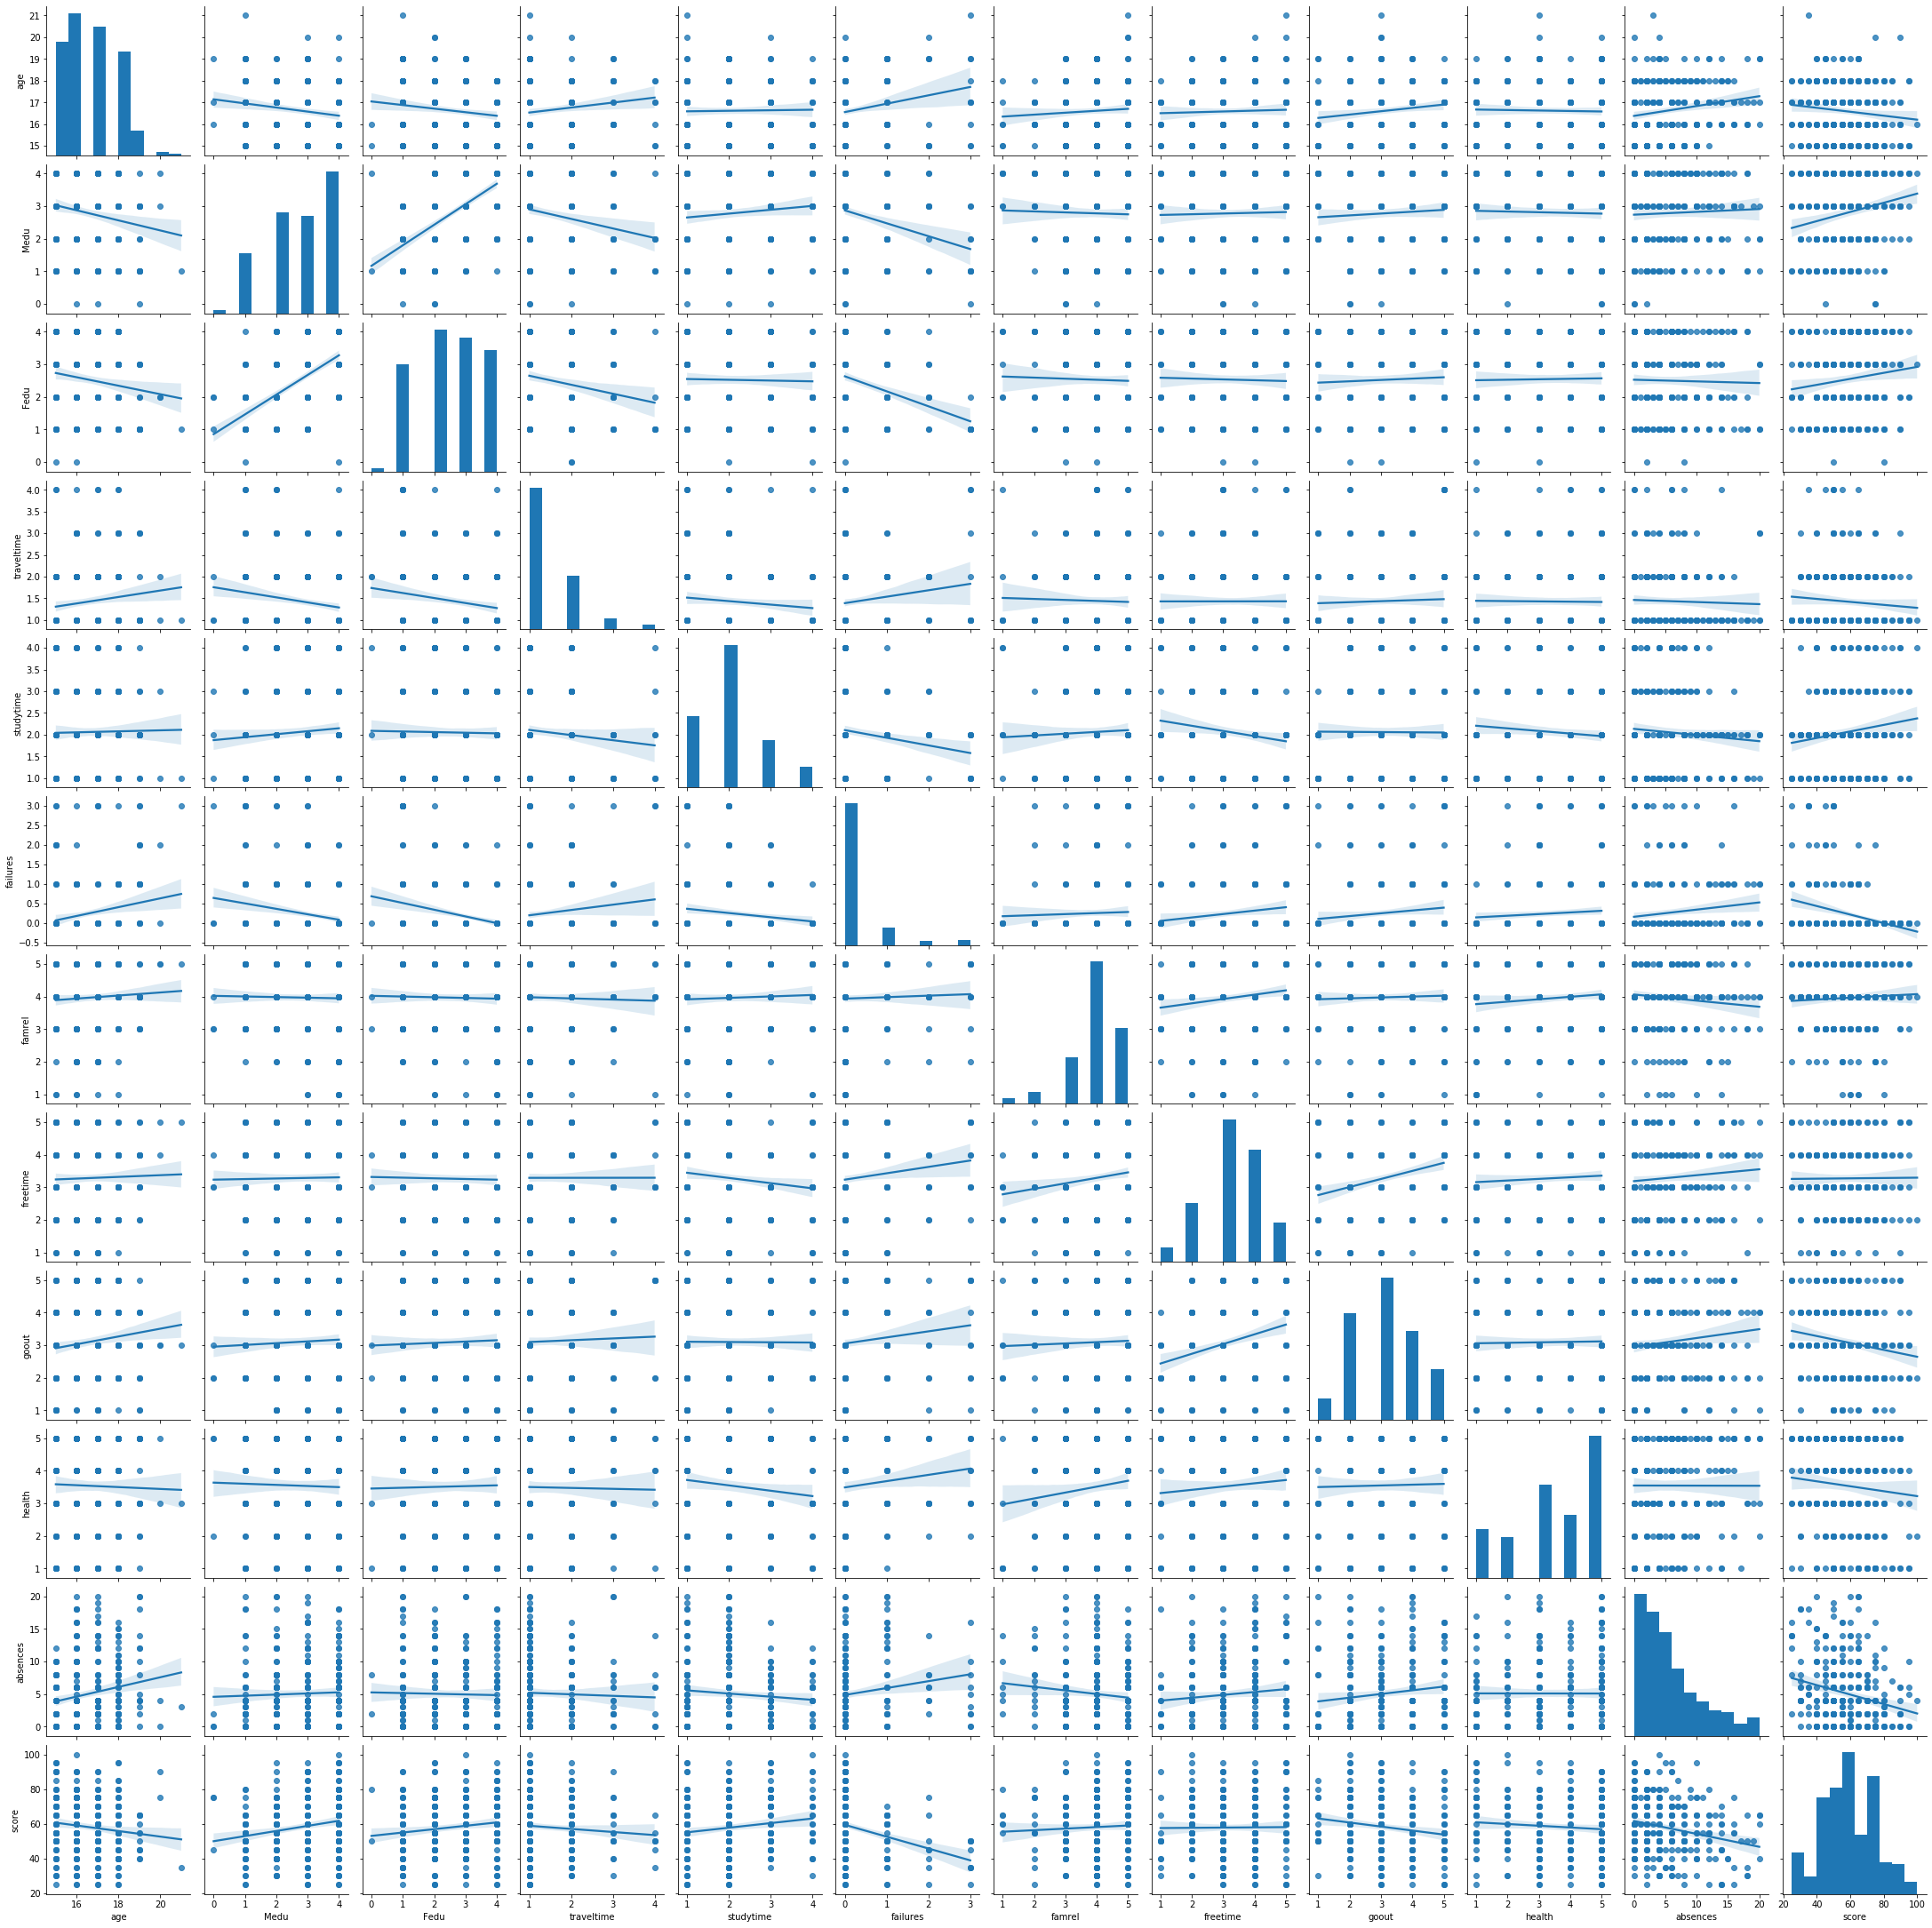

In [120]:
sns.pairplot(students, kind='reg')

Сложно сделать визуально вывод по этим парным диаграммам из-за больших разбросов значений в наборе.
Бросается в глаза только отрицательная корреляция между числом пропусков занятий и экзаменационной оценкой.

Полностью или сильно коррелирующих между собой величин не обнаружено.
(Колонка "studytime, granular", полностью коррелирующая с колонкой "studytime" по однозначной формуле (1) была удалена из набора с самого начала.)

### 5.3 Коэффициэнты корреляции влияющие на экзаменационные отметки.

In [121]:
correlations_score = correlations["score"]
display(correlations_score)

age          -0.120684
Medu          0.203378
Fedu          0.133429
traveltime   -0.078312
studytime     0.141107
failures     -0.272378
famrel        0.049663
freetime      0.008309
goout        -0.156448
health       -0.086752
absences     -0.232186
score         1.000000
Name: score, dtype: float64

Из столбца `correlations_score` для корреляционных коэффициентов для экзаменационных отметок видно, что<br />
могут иметься следующие положительные связи, влияющие на более высокий балл:
- Medu - score (0.203378): Чем выше уровень образования матери, тем выше отметка по математике;
- Fedu - score (0.133429): Чем выше уровень образования отца, тем выше отметка по математике;
- studytime - score (0.144783): Чем больше времени вне школы проведено за учёбой, тем выше отметка по математике;

Стоит также заметить, в предложенном наборе данных уровень образования у отцов в среднем ниже чем у матерей,
что могло повлиять на более низкое значение коэффициента корреляции Fedu - score (0.133429) по сравнению с
Medu - score (0.203378).

**Вывод 1:** Более высокий уровень образования родителей и большее время для занятий дома повышают вероятноть получения учеником более высоких баллов за гос. экзамен по математике.

*Несмотря на большую корреляцию между уровнем образования матери и отца (0.614686), стоит оставить оба эти параметра, поскольку они оба могут существенно влиять в паре на построение итоговой модели.*

---
0.078312
Из столбца `correlations_score` для корреляционных коэффициентов для экзаменационных отметок видно, что<br />
могут иметься следующие отрицательные связи, влияющие на более низкий балл:
 - age - score (-0.120684): Чем больше возраст ученика, тем более низкие отметки по математике он может получить;
 - failures - score (-0.272378): Чем больше у ученика было различных неудач, не связанных с учёбой в школе, тем обльше вероятность, что он получит плохие отметки на экзамене;
 - goout - score (-0.156448): Время, затраченное не на учёбу в школе, а на общение с друзьями понижает отметки по математике;
 - absences - score (-0.232186): Чем больше ученик пропускает занятий, тем больше вероятноть, что он получит более низкую отметку по матемеатике;
 - health - score (-0.086752): Имеется небольшая отрицательная корреляция между уровнем здоровья ученика и его отметкой по математике;
 - traveltime - score (-0.078312): Есть слабое отрицательное влияние увеличения времени поездки до школы на более низкую отметку по матекатике.

**Вывод 2:** У ученика, у которого повышен уровень внеучебных неудач, который часто пропускает занятия, тратит время не на учёбу, а на праздное общение с друзьями чаще всего получает более низкие отметки за гос. экзамен по математике. Эти отметки также могут ухудшаться при воздействии фактора возраста ученика: чем возраст выше, тем отметка по математике хуже. Небольшую добавку в ухудшение отметки может внести падение уровня здоровья учащегося и увеличение веремени, затрачиваемого на дорогу до школы.

---

Из столбца `correlations_score` для корреляционных коэффициентов для экзаменационных отметок видно, что<br />
имеются отсутствующие или низкие связи с некоторыми факторами, практически не влияющими на оценку по математике:
- famrel - score (0.049663): Имеется слабая положительная связь между отношениями в семье и отметкой по математике;
- freetime - score (0.008309): Практически отсутствует связь между личным свободным временем ученика и его отметкой по математике, из чего можно сделать вывод что это время он тратит исключительно на себя, а не на друзей (фактор groot).

**Вывод 3:** Личное свободное время ученика почти никак не влияяет на его отметку за гос. экзамен по математике.
Улучшение семейных отношений может очень слабо повлиять на увеличение отметки.

### 5.5 Переменные, не коррелирующие с отметкой за экзамен:
- freetime

Принято решение исключить переменную freetime из итоговой модели.

### 5.6 Дублирующиеся переменные, полностью коррелирующие:
- "studytime, granular";
- studytime

Принято решение оставить только переменную studytime.

### 5.5 Коррелирующие с преременной score переменные, влияющие на отметку за экзамен:
- Положительно коррелирующие:
  - Medu;
  - Fedu;
  - studytime;
- Отрицательно коррелирующие:
  - age;
  - failures;
  - goout;
  - absences;
  - traveltime

**Вывод 4:** Принято решение включить указанные переменные в итоговую модель:<br />
`Medu`, `Fedu`, `studytime`, `age`, `failures`, `goout`, `absences`, `traveltime`.


## 6. Анализ номинативных переменных

### 6.1 Распечатка всех переменных подготовленного набора данных

In [122]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      338 non-null    object 
 1   sex         338 non-null    object 
 2   age         338 non-null    int64  
 3   address     322 non-null    object 
 4   famsize     316 non-null    object 
 5   Pstatus     304 non-null    object 
 6   Medu        336 non-null    float64
 7   Fedu        318 non-null    float64
 8   Mjob        323 non-null    object 
 9   Fjob        307 non-null    object 
 10  reason      323 non-null    object 
 11  guardian    310 non-null    object 
 12  traveltime  315 non-null    float64
 13  studytime   331 non-null    float64
 14  failures    321 non-null    float64
 15  schoolsup   329 non-null    object 
 16  famsup      305 non-null    object 
 17  paid        302 non-null    object 
 18  activities  326 non-null    object 
 19  nursery     325 non-null    o

### 6.2 Анализ номинативных переменных `school`, `sex`, `address`, `famsize`, `Pstatus`

#### Диаграммы Boxplot

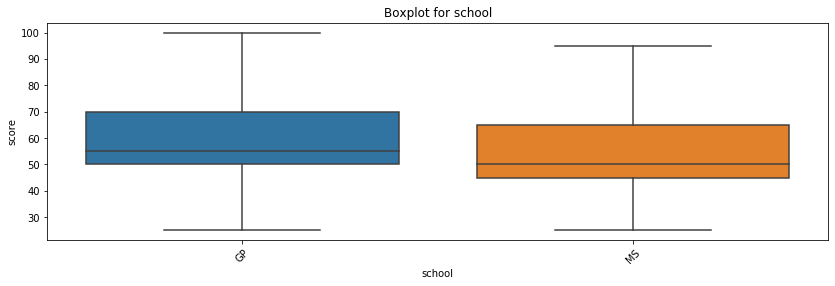

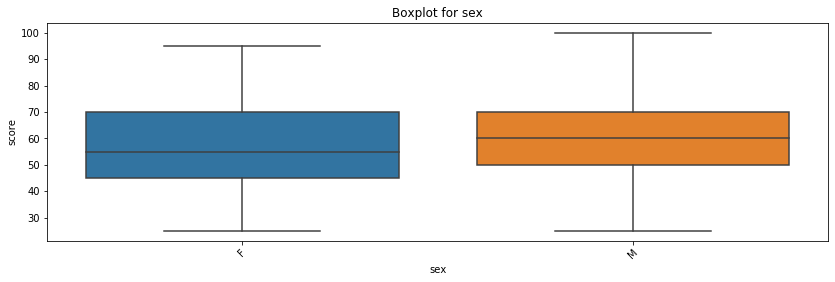

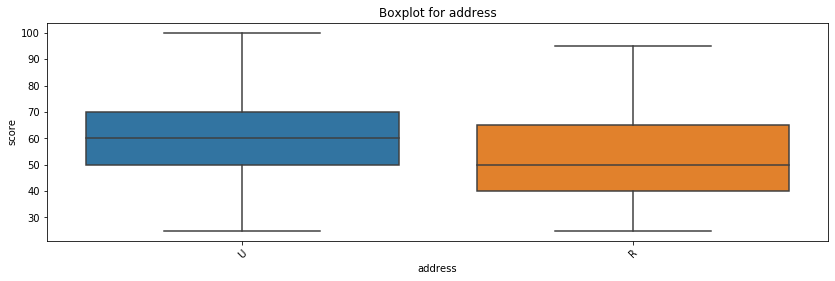

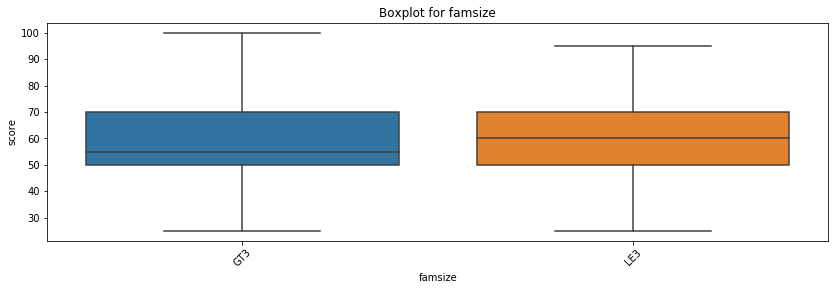

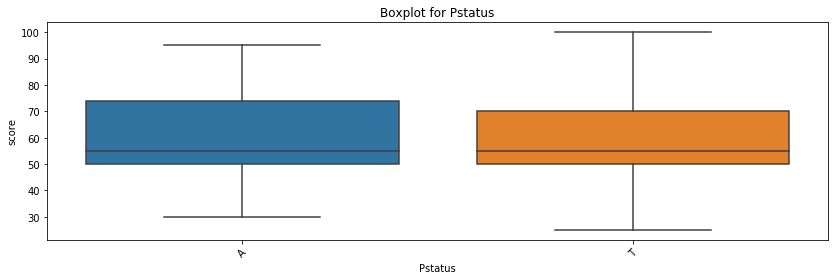

In [123]:
for column_x in ["school", "sex", "address",
            "famsize", "Pstatus"]:
    get_boxplot(students, column_x, students.score)

Из графиков *визуально* видно, что следующие номинативные переменные **мало влияют** на отметки за гос. экзамен по математике:
- `famsize`;

Из графиков *визуально*  видно, что следующие номинативные переменные **влияют** на отметки за гос. экзамен по математике:
- `school`;
- `sex`;
- `address`;
- `Pstatus`.

#### Тест Стьюдента

In [124]:
for column in ["school", "sex", "address", "famsize", "Pstatus"]:
    find_statistical_differences(students, column, "score")

☒ Статистически значимых различий для номинативных данных (различных значений) колонки "school" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "sex" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "address" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "famsize" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "Pstatus" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.


### 6.3 Анализ номинативных переменных `Mjob`, `Fjob`, `reason`, `guardian`, `schoolsup`

#### Диаграммы Boxplot

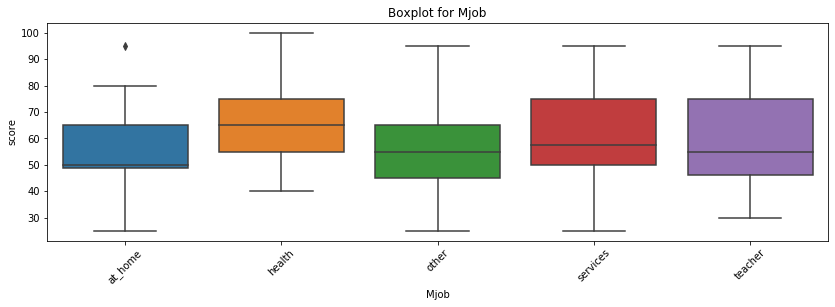

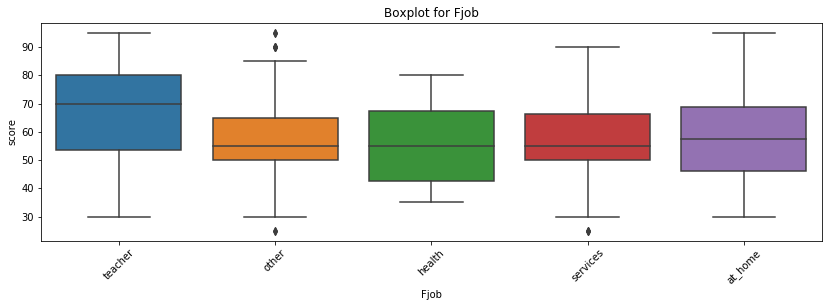

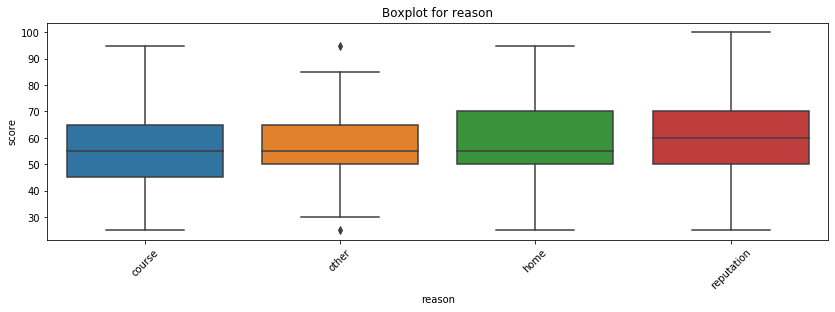

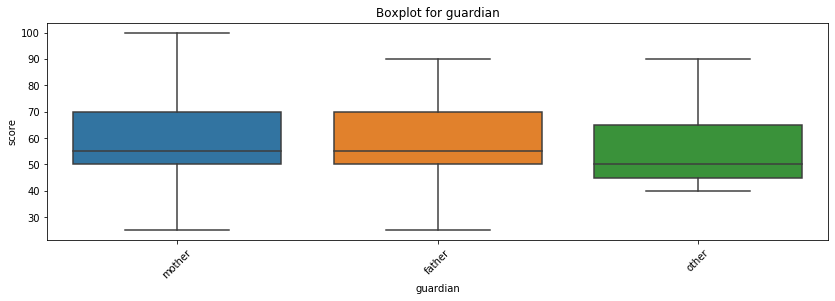

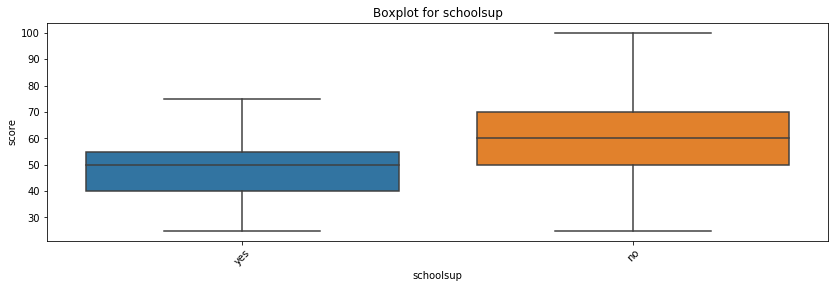

In [125]:
for column_x in ["Mjob", "Fjob",
                 "reason", "guardian",
                 "schoolsup"]:
    get_boxplot(students, column_x, students.score)

Из графиков *визуально* видно, что следующие номинативные переменные **мало влияют** на отметки за гос. экзамен по математике:
- `reason`;

Из графиков *визуально* видно, что следующие номинативные переменные **влияют** на отметки за гос. экзамен по математике:
- `Mjob`;
- `Fjob`;
- `guardian`;
- `schoolsup`.

#### Тест Стьюдента

In [126]:
for column in ["Mjob", "Fjob", "reason", "guardian", "schoolsup"]:
    find_statistical_differences(students, column, "score")

☑ Найдены статистически значимые различия для номинативных данных (различных значений) колонки "Mjob" по отношению к значениям в колонке "score"
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "Fjob" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "reason" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "guardian" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "schoolsup" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.


### 6.4 Анализ номинативных переменных `famsup`, `paid`, `activities`, `nursery`, `higher`

#### Диаграммы Boxplot

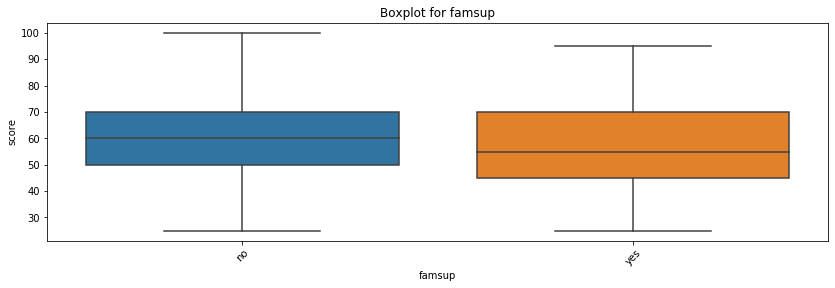

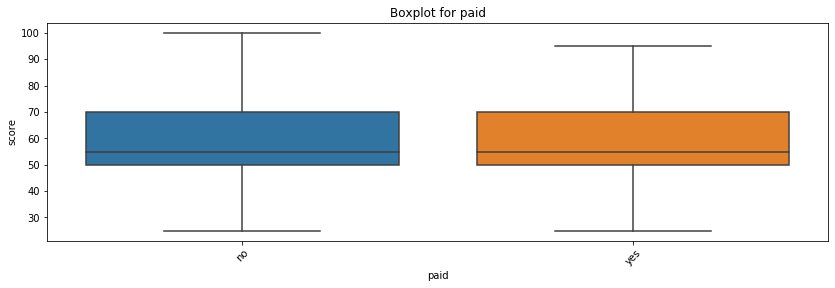

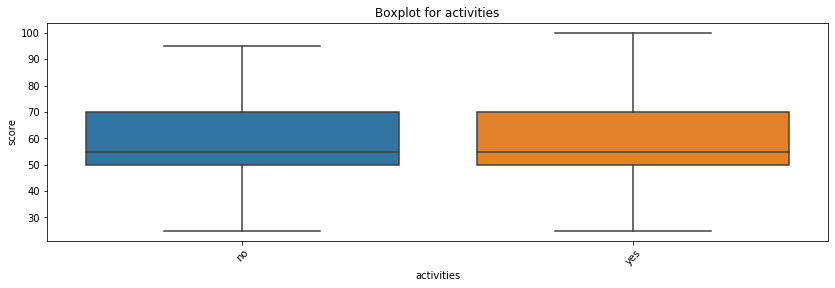

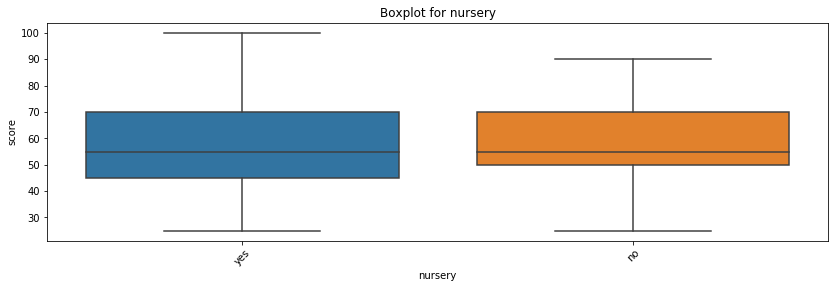

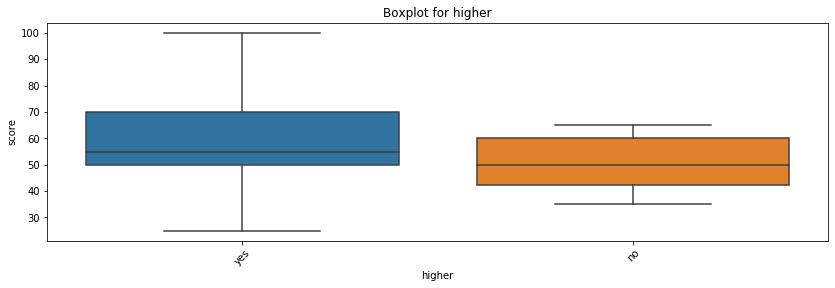

In [127]:
for column_x in ["famsup", "paid",
                 "activities", "nursery",
                 "higher"]:
    get_boxplot(students, column_x, students.score)

Из графиков *визуально* видно, что следующие номинативные переменные **мало влияют** на отметки за гос. экзамен по математике:
- `paid`;
- `activities`;

Из графиков *визуально* видно, что следующие номинативные переменные **влияют** на отметки за гос. экзамен по математике:
- `famsup`;
- `nursery`;
- `higher`.

#### Тест Стьюдента

In [128]:
for column in ["famsup", "paid", "activities", "nursery", "higher"]:
    find_statistical_differences(students, column, "score")

☒ Статистически значимых различий для номинативных данных (различных значений) колонки "famsup" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "paid" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "activities" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "nursery" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "higher" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.


### 6.5 Анализ номинативных переменных `internet`, `romantic`

#### Диаграммы Boxplot

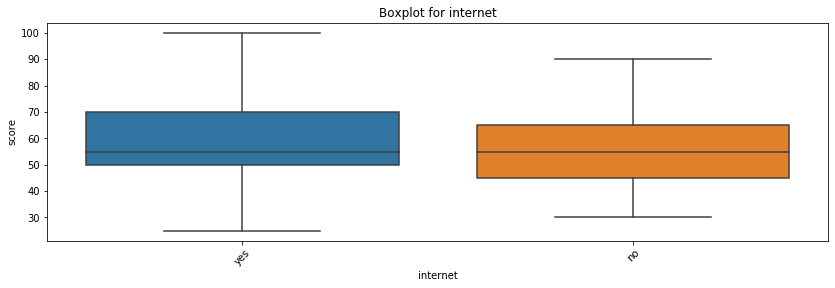

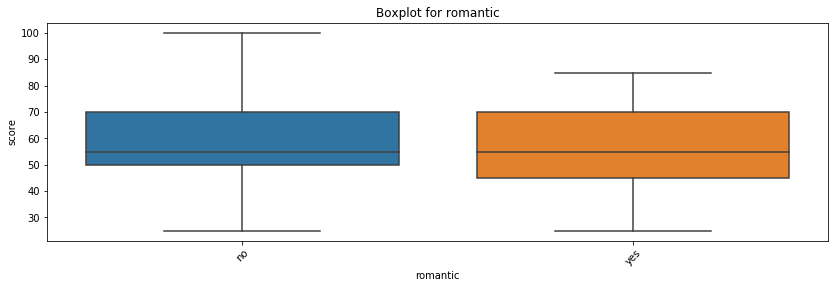

In [129]:
for column_x in ["internet", "romantic"]:
    get_boxplot(students, column_x, students.score)

Из графиков *визуально* видно, что следующие номинативные переменные **влияют** на отметки за гос. экзамен по математике:
- `internet`;
- `romantic`.

#### Тест Стьюдента

In [130]:
for column in ["internet", "romantic"]:
    find_statistical_differences(students, column, "score")

☒ Статистически значимых различий для номинативных данных (различных значений) колонки "internet" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.
☒ Статистически значимых различий для номинативных данных (различных значений) колонки "romantic" по отношению к значениям в колонке "score" НЕ НАЙДЕНО.


### 6.6 Номинативные переменные, которые включаются в набор, как прошедшие тест Стьюдента на наличие статистических отличий при выборок с их фиксированными значения и переменной `score` (отметка за экзамен)

Тест Стьюдента на наличие статистических различий для разных групп записей с разными уникальными значениями номинативной переменной прошла только переменная `Mjob` (работа, профессия матери).

Возможно, что другие переменные, различия для которых обнаруживаются визуально на boxplot диаграммах, будут включены в седующие усовершенствованные версии моделей, если будут предоставлены новые наборы данных с более полными выборками.
Эти потенциальные кандидаты таковы: `school`, `sex`, `address`, `Pstatus`, `Fjob`, `guardian`, `schoolsup`, `famsup`, `nursery`, `higher`.

В текущую модель из всех номинативных переменных, прошедших тест Стьюдента включается только переменная `Mjob`.

## 7. Оценка корректности всех выдвинутых гипотез

<span style="color: green">**Гипотеза 1:**</span> Чем больше возраст у ученика (`age`), тем ниже отметки за гос. экзамен по математике у таких учеников.<br />
**Оценка:** Соответствующий коэффициент коррреляции - `-0.120684`, поэтому **Гипотеза 1** верна с высокой долей уверенности.

<span style="color: green">**Гипотеза 2:**</span> Чем выше уровень образования матери (`Medu`), тем выше отметки за гос. экзамен по математике у таких учеников.<br />
**Оценка:** Соответствующий коэффициент коррреляции - `0.203378`, поэтому **Гипотеза 2** верна с высокой долей уверенности.

<span style="color: green">**Гипотеза 3:**</span> Чем выше уровень образования отца (`Fedu`), тем выше отметки за гос. экзамен по математике у таких учеников.<br />
**Оценка:** Соответствующий коэффициент корреляции - `0.133429`, поэтому **Гипотеза 3** верна с высокой долей уверенности.

<span style="color: green">**Гипотеза 4:**</span> Чем дольше добираются ученики до школы (`traveltime`), тем ниже отметка за гос. экзамен по математике у таких учеников.<br />
**Оценка:** Соответствующий коэффициент корреляции - `-0.078312`, поэтому можно с небольшой долей уверенности сказать, что **Гипотеза 4** верна. Возможно нужны другие, более репрезентативные выборки, для улучшения результата.

<span style="color: green">**Гипотеза 5:**</span> Чем больше внешкольного времени (`studytime`) проводях ученики дома за занятиями дома, тем выше отметки за гос. экзамен по математике у таких учеников.<br />
**Оценка:** Соответствующий коэффициент корреляции - `0.141107`, поэтому **Гипотеза 5** верна с высокой долей уверенности.

<span style="color: green">**Гипотеза 6:**</span> Чем больше внешкольных неудач (`failures`) (проигрыш в спортивных соревнованиях, личные проблемы и т.п.) у учеников, тем ниже отметки за гос. экзамен по математике у таких учеников.<br />
**Оценка:** Соответствующий коэффициент корреляции - `-0.272378`, поэтому **Гипотеза 6** верна с высокой долей уверенности.

<span style="color: red">**Гипотеза 7:**</span> Возможно, что чем лучше семейные отношения (`famrel`) у учеников, тем выше отметки за гос. экзамен по математике у таких учеников.<br />
**Оценка:** Соответствующий коэффициент корреляции - `0.049663`, поэтому **Гипотеза 7** *на данной выборке* не верна с большой долей уверенности. Возможно показатель уровня семейных отношений требует намного больших выборок.

<span style="color: red">**Гипотеза 8:**</span> Возможно, что чем больше неучебного свободного времени (`freetime`) тратят ученики, тем ниже отметки за гос. экзамен по математике у таких учеников.<br />
**Оценка:** Соответствующий коэффициент корреляции - `0.008309`, поэтому **Гипотеза 8** *на данной выборке* не верна с очень высокой долей уверенности.

<span style="color: green">**Гипотеза 9:**</span> Возможно, что чем больше времени тратят ученики на общение с друзьями (`goout`), тем ниже отметки за гос. экзамен по математике у таких учеников.<br />
**Оценка:** Соответствующий коэффициент корреляции - `-0.156448`, поэтому **Гипотеза 9** верна с высокой долей уверенности.

<span style="color: green">**Гипотеза 10:**</span> Возможно, что чем хуже здоровье (`health`) у учеников, тем ниже отметки за гос. экзамен по математике у таких учеников.<br />
**Оценка:** Соответствующий коэффициент корреляции - `-0.086752`, поэтому можно с небольшой долей уверенности сказать, что **Гипотеза 10** верна. Возможно нужны другие, более репрезентативные выборки, для улучшения результата.

<span style="color: green">**Гипотеза 11:**</span> Возможно, что чем больше ученики пропускают занятия (`absences`), тем ниже отметки за гос. экзамен по математике у таких учеников.<br />
**Оценка:** Соответствующий коэффициент корреляции - `-0.232186`, поэтому **Гипотеза 11** верна с высокой долей уверенности.

<span style="color: red">**Гипотеза 12:**</span> У учеников, живущих за городом оценки отличаются от городских жителей (`address`).<br />
**Оценка:** Переменная `address` не прошла тесть Стьюдента, поэтому **Гипотеза 12** гипотеза не верна на данной выборке. Однако, на соответствующей диаграмме boxplot видно, что медианные оценки по математике у учеников, живущих в селе ниже, чем у учеников, жиущих в городе. Требуется больше данных в более крупных выборках.

<span style="color: red">**Гипотеза 13:**</span> У учеников, чьи родители не живут вместе, оценки могут быть ниже (`Pstatus`).<br />
**Оценка:** переменная `Pstatus` не прошла тест Стьюдента, поэтому **Гипотеза 13** не верна на данной выборке.
На соответствующей диаграмме boxplot видно, что медианные оценки по математике у учеников, у которых родители живут вместе или по отдельности практически совпадат.

<span style="color: green">**Гипотеза 14:**</span> Работа, профессия, матери (`Mjob`) может влиять на оценки ученика.<br />
**Оценка:** переменная `Mjob` **прошла тест Стьюдента**, поэтому **Гипотеза 14** верна и эта номинативная переменная будет включена в итоговый набор данных для построения модели.

<span style="color: red">**Гипотеза 15:**</span> Работа, профессия, отца (`Fjob`) может влиять на оценки ученика.<br />
**Оценка:** переменная `Fjob` не прошла тест Стьюдента, поэтому **Гипотеза 15** не верна на данной выборке и эта номинативная переменная не будет включена в итоговый набор данных для построения модели.
Однако, она может быть включена в будещие наборы данных при наличии более крупных выборок наряду с переменной `Mjob` (!).

<span style="color: red">**Гипотеза 16:**</span> Ученики, у которых нет в опекунах ни матери, ни отца, могут иметь более низкие отметки за экзамен.
<span style="color: red">**Гипотеза 17:**</span> Доля других опекунов (ни отец, ни мать) мала в этой выборке и, скорее всего, не повлияет на итоговые выводы (`guardian`).<br />
**Оценка:** переменная `guardian` не прошла тест Стьюдента, поэтому **Гипотеза 16** и **Гипотеза 17** не верны на данной выборке и эта номинативная переменная не будет включена в итоговый набор данных для построения модели.
Однако, на соответствующей диаграмме boxplot видно, что медианные оценки по математике у учеников, у которых нет в опекунах, ни матери ни отца, ниже, чем медианные оценки учеников, у которых есть отец или мать в опекунах.
Нужны более большие выборки.

<span style="color: red">**Гипотеза 18:**</span> Возможно, что та часть учеников, которая имеет образовательную поддержку (`schoolsup`) будет иметь и более высокие баллы по математике.<br />
**Оценка:** переменная `schoolsup` не прошла тест Стьюдента, поэтому **Гипотеза 18** не верна на данной выборке и эта номинативная переменная не будет включена в итоговый набор данных для построения модели.
Однако, на соответствующей диаграмме boxplot видно, что медианные оценки по математике у учеников, у которых есть дополнительная школьная образовательная поддержка, ниже, чем медианные оценки учеников, у которых дополнительной школьной образовательной поддержки нет. Нужны более большие выборки.

<span style="color: red">**Гипотеза 19:**</span> Возможно, что та часть учеников, которая не имеет семейной образовательной поддержки (`famsup`) будет иметь и более низкие баллы по математике.<br />
**Оценка:** переменная `famsup` не прошла тест Стьюдента, поэтому **Гипотеза 19** не верна на данной выборке и эта номинативная переменная не будет включена в итоговый набор данных для построения модели.
Однако, на соответствующей диаграмме boxplot видно, что медианные оценки по математике у учеников, у которых есть дополнительная семеная образовательная поддержка, ниже, чем медианные оценки учеников, у которых дополнительной семейно образовательной поддержки нет. Нужны более большие выборки.

<span style="color: red">**Гипотеза 20:**</span> Возможно, что та часть учеников, которая брала дополнительные платные занятия по математике (`paid`) будет иметь и более высокие баллы на экзамене.<br />
**Оценка:** переменная `paid` не прошла тест Стьюдента, поэтому **Гипотеза 20** не верна на данной выборке и эта номинативная переменная не будет включена в итоговый набор данных для построения модели.
На соответствующей диаграмме boxplot также видно, что медианные оценки по математике у учеников, которые брали дополнительные платные занятия по математике почти не отличаются от тех, кто эти занятия не покупали.

<span style="color: red">**Гипотеза 21**</span> Возможно, что та часть учеников, которая брала дополнительные внеучебные занятия (`activities`) будет иметь и более высокие баллы на экзамене.<br />
**Оценка:** переменная `activities` не прошла тест Стьюдента, поэтому **Гипотеза 21** не верна на данной выборке и эта номинативная переменная не будет включена в итоговый набор данных для построения модели.
На соответствующей диаграмме boxplot также видно, что медианные оценки по математике у учеников, которые брали дополнительные внеучебные занятия по математике почти не отличаются от тех, кто эти занятия не покупали.

<span style="color: red">**Гипотеза 22:**</span> Скорее всего наличие или отсутствие желания получать высшее образование (`higher`) не влияет на баллы за экзамен для основной массы учеников в процентном соотношении из-за подавляющего большинства, желающего это высшее образование иметь.<br />
**Оценка:** переменная `higher` не прошла тест Стьюдента, поэтому **Гипотеза 22** не верна на данной выборке и эта номинативная переменная не будет включена в итоговый набор данных для построения модели.
Однако, на соответствующей диаграмме boxplot видно, что медианные оценки по математике у учеников, у которые не рассматривают для себя возможность получения высшего образования, ниже чем у тех, кто хочет получить высшее образование. Доля учеников желающих получить высшее образование - `96.3%`, а доля учеников, которые не хотят иметь высшее образование - `3.7%`. Нужны более большие выборки.

<span style="color: red">**Гипотеза 23:**</span> Скорее всего отсутствие интернета дома (`internet`) и доступа к дополнительным материалам и общению со студентами негативно может сказаться в среднем на баллах за экзамен.<br />
**Оценка:** переменная `intеrnet` не прошла тест Стьюдента, поэтому **Гипотеза 23** не верна на данной выборке и эта номинативная переменная не будет включена в итоговый набор данных для построения модели.
Однако, на соответствующей диаграмме boxplot видно, что интерквартильный размах оценок по математике у учеников, у которых есть дома интернет, расположен немного выше, чем интерквартильный размах оценок учеников, у которых нет домашнего интернет. Нужны более большие выборки.

## 8 Дополнительный вывод по ученикам,<br />не сдававшим экзамен, имеющим оценку `0`

Возможно, некоторая значительная часть учеников (37) могут испытывать ухудшение здоровья,<br />
поэтому они проводят больше своего времени с семьёй и друзьями<br />
и большая часть из них (33) учится в школе "GP".<br />
<ins>Возможно, что школе "GP" следует плотнее заняться поддержкой таких студентов.</ins>

Данные для указанных студентов были оценены как выброс и не были включены в итоговый набор данных.

## 9. Итоговый набор переменных для влючения в набор данных для создания модели

- `age` - возраст ученика;
- `Medu` - образование матери;
- `Fedu` - образование отца;
- `traveltime` - время в пути до школы;
- `studytime` - время на учёбу помимо школы в неделю;
- `failures` - количество внеучебных неудач;
- `goout` - проведение времени с друзьями;
- `health` - текущее состояние здоровья;
- `absences` - количество пропущенных занятий;
- `Mjob` - работа матери.

## 10. Итоговый набор данных для построения модели

In [131]:
students_for_model = students.loc[:, ["age", "Medu", "Fedu", "Mjob", "traveltime", "studytime", "failures", "goout", "health", "absences"]]
print(f"Количество записей в итоговом наборе данных: {len(students_for_model.index)}")
display(students_for_model)

Количество записей в итоговом наборе данных: 338


,age,Medu,Fedu,Mjob,traveltime,studytime,failures,goout,health,absences
0,18,4.0,4.0,at_home,2.0,2.0,0.0,4.0,3.0,6.0
1,17,1.0,1.0,at_home,1.0,2.0,0.0,3.0,3.0,4.0
2,15,1.0,1.0,at_home,1.0,2.0,3.0,2.0,3.0,10.0
3,15,4.0,2.0,health,1.0,3.0,0.0,2.0,5.0,2.0
4,16,3.0,3.0,other,1.0,2.0,0.0,2.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...
388,18,3.0,1.0,teacher,1.0,2.0,0.0,4.0,1.0,0.0
391,17,3.0,1.0,services,2.0,1.0,0.0,5.0,2.0,3.0
392,21,1.0,1.0,other,1.0,1.0,3.0,3.0,3.0,3.0
393,18,3.0,2.0,services,3.0,1.0,0.0,1.0,5.0,0.0


In [132]:
students_for_model.head()

,age,Medu,Fedu,Mjob,traveltime,studytime,failures,goout,health,absences
0,18,4.0,4.0,at_home,2.0,2.0,0.0,4.0,3.0,6.0
1,17,1.0,1.0,at_home,1.0,2.0,0.0,3.0,3.0,4.0
2,15,1.0,1.0,at_home,1.0,2.0,3.0,2.0,3.0,10.0
3,15,4.0,2.0,health,1.0,3.0,0.0,2.0,5.0,2.0
4,16,3.0,3.0,other,1.0,2.0,0.0,2.0,5.0,4.0


## 11. Выводы

В результате EDA для анализа влияния различных факторов в процессе обучения студента в школе на оценку, полученную им при сдаче государственного экзамена по математике были получены следующие выводы:

- В наборе данных присутствует *небольшое* количество пустых значений в различных номминативных переменных таких как `address`, `famsize`, `Pstatus`, `Mjob`, `Fjob`, `reason`, `guardian`, `schoolsup`, `famsup`, `paid`, `activities`, `nursery`, `higher`, `internet`, `romantic`. Однако эти случаи не носят систематического характера и поэтому данные из исходной таблицы могут быть использованы для анализ в этих переменных.
- Для числовых переменных также имеются пустые значения (`NaN`), которые тоже не имеют массового характера.
- Удалена переменная `"studytime, granular"`, которая полность корелирует с переменной `studytime`
  по правилу $\text{"studytime, granular"} = -3.0 \cdot \text{studytime}$
- Выбросы найдены для переменных (колонок):
  - `age` - был найден только один выброс со значением 22, было принято решение его удалить;
  - `Fedu` - удалена 1 запись с неверным значением `40.0`;
  - `famrel` - удалена 1 запись с неверным значением `-1.0`;
  - `absences` - было удалено 17 выбросов с экстремально большими количествами пропусков занятий;
  - `score`- было удалено 37 выбросов, которые касались тех студентов, у которых была нулевая отметка за экзамен,
     указанные студенты были исследованы отдельно, по ним был сделан дополнительный вывод насколько это было 
     возможно;
  - Всего было удалено *57* записей, которые либо являются выбросами, либо соответствую необычным значениям
    (нулевая отметка за экзамен), либо выходят за границы своих доменов;
- Найдены ненулевые и не полные корреляции с оценкой `score` за гос. экзамен по математике:
  - Положительно коррелирующие:
    - Medu - чем выше уровень образования матери, тем выше отметки за гос. экзамен по математике у таких 
      учеников;
    - Fedu - чем выше уровень образования отца (Fedu), тем выше отметки за гос. экзамен по математике у таких 
      учеников;
    - studytime - чем больше внешкольного времени проводят ученики дома за занятиями дома, тем выше отметки за гос. 
      экзамен по математике у таких учеников;
  - Отрицательно коррелирующие:
    - age - чем больше возраст у ученика, тем ниже отметки за гос. экзамен по математике у таких учеников;
    - failures - чем больше внешкольных неудач (проигрыш в спортивных соревнованиях,
      личные проблемы и т.п.) у учеников, тем ниже отметки за гос. экзамен по математике у таких учеников;
    - goout - чем больше времени тратят ученики на общение с друзьями, тем ниже отметки
      за гос. экзамен по математике у таких учеников;
    - absences - чем больше ученики пропускают занятия, тем ниже отметки
      за гос. экзамен по математике у таких учеников;
    - traveltime - чем дольше добираются ученики до школы, тем ниже отметка
      за гос. экзамен по математике у таких учеников.
- Найдены статистические различия по критерию Стьюдента для номинативной переменой `Mjob` в отношении
  оценок учеников за гос. экзамен по математике.
- Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это:
  - `age` - возраст ученика;
  - `Medu` - образование матери;
  - `Fedu` - образование отца;
  - `traveltime` - время в пути до школы;
  - `studytime` - время на учёбу помимо школы в неделю;
  - `failures` - количество внеучебных неудач;
  - `goout` - проведение времени с друзьями;
  - `health` - текущее состояние здоровья;
  - `absences` - количество пропущенных занятий;
  - `Mjob` - работа матери.

## Дополнительный комментарий по своей работе для ментора:

- Возможно некоторые числовые переменные можно было бы сделать номинативными, но мне показалось, что так проще считать по ним корреляции: `Medu`, `Fedu`, `traveltime`, `studytime`. У них всё равно можно увидеть элементарные шкалы числовых значений;
- Некоторые номинативные переменные явно влияют на оценки `score`, как мне кажется, но они не прошли тесты Стьюдента. Например `address`, `Fjob`, `guardian`, `schoolsup`, `famsup`, `higher`, `internet`. Возможно нужны более крупные наборы данных.